# Assignment 1. Coding 1 by [Rufaim](https://github.com/Rufaim)

---

Implement UCB and Thompson sampling for a simple 2-arm bandit setting described in the following parts.

 **Part 1**. Consider the setting where the reward distributions of the bandit arms are independent Bernoulli (rewards for each arm $i$ is $1$ with probability $p_i$ and $0$ with probability $1−p_i$ ), where the parameter $p_i$ for each arm are sampled independently and uniformly over [0, 1]. Test UCB and Thompson sampling algorithms in this setting.
 
 **Part 2**. In this part, consider Bernoulli distributions where the parameters $p_1$ and $p_2$ of the two arms are correlated. Specifically, $p_2 = 1 − p_1$. Consider the following setting for selecting the parameter $p_1$:
 1. uniform - means that $p_1 \sim U (0, 1)$ (uniform distribution over the unit interval)
 2. easy - means that $p_1 \sim U (0.1, 0.9)$ (uniform distribution over those two possible values)
 3. medium - $p_1 \sim U (0.25, 0.75)$ 
 4. hard - $p_1 \sim U (0.4, 0.6)$. 

For each setting, please plot the following graphs: average training return (averaged over 10 independent runs), average regret per step (which you can compute in this case, as we know a priori the best arm) and a testing plots (showing the reward of the optimal policy, computed after every 10 pulls, and averaged over 5 pulls). Explain what you expect to see and what you actually saw.

## Imports and Global constants

In [1]:
import numpy as np
import matplotlib.pyplot as pyplot

In [2]:
from scipy.special import softmax

By default we assume that we are working with 10-armed bandit problems.
The total number of pulling arms is 1000.

In each experiment we averaging over 10 independent runs with differend seeds.


---


Default global settings:

```python
RUNS_TO_AVERAGE = 10
NUMBER_OF_ARMS = 10
TIMESAMPLES = 1000
SEED = 42
```

**Note**: Default settings are asumed for algorithms descriptions


In [3]:
RUNS_TO_AVERAGE = 10
NUMBER_OF_ARMS = 10
TIMESAMPLES = 1000
SEED = 42

## Multi Armed Bandit

In this section there will be a base class for Multi Armed Bandit environment and
a subclass for a bandit with normally distributed rewards. 

### Base class for problem

Every bandit problem  is characterized by number of arms (it is *Multi* Armed Bandit, after all!) and total number of pulls.

In order to maintain reprodusability here and below all problems and agents have a seed parameter.
The seed is used to fix state of interanal pseudo random generator. 
Every generator for problem or agent is independent from others.


```python
    ...
    self.random_generator = np.random.RandomState(seed=seed)
    ...
```

For all problems all rewards during play session are pregenerated. Therefore we have determenistic play session, so outputs of a particular arm of given timestep is always the same.



In [4]:
class MultiArmBandit(object):
    def __init__(self,n_arms=10,max_timesteps=2000,seed=None):
        #fix random generator for reproducibility
        self.random_generator = np.random.RandomState(seed=seed)

        self.n_arms = n_arms
        self.max_timesteps = max_timesteps

        #pregenerate all outcomes for the same reproducibility reasons
        self.rewards_array = None
        self.initalize_arms()

        self.current_timestep = None
        self.reset()
    
    def reset(self):
        self.current_timestep = 0
    
    def step(self,action):
        '''
        action (int) : index of arm choosen by agent 

        returns : reward and regret for action
        '''
        assert 0<= action < self.n_arms, f"Invalid arm index given, recieved {action}"

        out = self.rewards_array[action,self.current_timestep]
        best_out = self.rewards_array[self.get_best_arm(),self.current_timestep]
        self.current_timestep += 1
        return out, best_out - out 
    
    ### Methods below this line is to be redefined in subclasses ###

    def initalize_arms(self):
        '''
        The method is used to define distribution of rewards for arms 
        '''
        pass

    def plot(self):
        '''
        Plots distribution of rewards for arms 
        '''
        pass
    
    def get_best_arm(self):
        '''
        Returns INDEX of the arm with the highest expected reward
        '''
        pass

### Multi Armed Bandit Normal

The first problem we have is a Multi Armed Bandit with normally distributed rewards. 

$$
\forall arm \in [1..10] \quad R^{arm}_{time} \sim \mathcal{N}(\mu_{arm},\,1)\, \quad \mu_{arm} \sim \mathcal{N}(\mu_{arm},\,2)\,.
$$


In [5]:
class MultiNormalArmBandit(MultiArmBandit):    
    def initalize_arms(self):
        # rewards and their expectations are pregenerated and fixed in table format, as it has been mentioned above
        self.true_q_values = self.random_generator.normal(0,2,size=self.n_arms)
        self.rewards_array = self.random_generator.normal(0,1,size=(self.n_arms,self.max_timesteps)) + self.true_q_values[:,None]
    
    def plot(self):
        labels = list(range(1,11))
        inds = np.arange(1, len(labels) + 1)

        pyplot.figure()
        ax = pyplot.gca()
        ax.axhline(y=0,linestyle="--",color="k")
        ax.violinplot([self.rewards_array[i,:] for i in range(10)], showmeans=False, showmedians=False,showextrema=False)

        ax.scatter(inds, self.true_q_values, marker='o', color='k', s=30, zorder=3)

        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(inds)
        ax.set_xticklabels(labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        ax.set_xlabel('Actions')
        ax.set_ylabel("Reward distribution")
        ax.set_title("Multi Armed Bandit with Normal rewards")
    
    def get_best_arm(self):
        # since expectation are known best arm is easy to find
        return np.argmax(self.true_q_values)

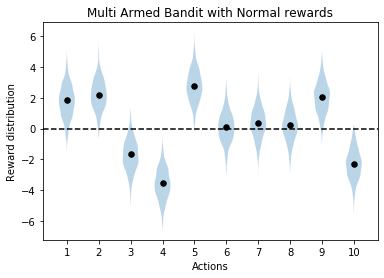

In [6]:
mnab = MultiNormalArmBandit(NUMBER_OF_ARMS,TIMESAMPLES)
mnab.plot()

## Solution preliminaries

In this section you will see solvers for all Multi Arm Bandit problem solvers and a framework for testing them.

### Base class for Agents

Each agent is need to know number of arms that is possible to play. As well as for problem class seed is passed to agent internal pseudo random generator.

Generally an agent of a particular type have a special way to estimate its own preference (which we treat as probabilities) about arms to choose. Thus there are two possible ways of choosing the action. First one is sampling from distribution and the second is to greedily choose the maximum of probability.

Unlike ploblem, we do not require an agent to be deterministic over each step during play session. However, for reproducibility agent shall be able to produce the same sequence of outputs during replay given unchanged problem instance.

In [7]:
class BanditAlgorithm(object):
    def __init__(self, num_arms,seed):
        self.num_arms = num_arms
        self.random_generator = np.random.RandomState(seed=seed)
        self._init_state = self.random_generator.get_state()

    def reset(self):
        self.random_generator.set_state(self._init_state)
        # note that meaning of values is differend for differend agents!
        self.values = np.zeros((self.num_arms,))
        self.num_taken = np.zeros((self.num_arms,))
        self._reset()

    def get_action(self):
        '''
        Greedy way to evaluate policy
        '''
        return np.argmax(self._proba())
    
    def sample_action(self):
        '''
        Sampling from action distribution given agent's arm preferences
        '''
        return self.random_generator.choice(np.arange(0,self.num_arms),p=self._proba())

    ### Methods below is to be redefined in subclasses ###

    def _reset(self):
        '''
        Used by subclass to reset internal state
        '''
        pass
    
    def _proba(self):
        '''
        Returns distribution over arms
        '''
        pass
    
    def update(self,action,reward):
        '''
        Used by subclass to updade in according to an algprithm
        '''
        pass

The following agent is treated as baseline.

Random agent, consistently to its name, picks arms randomly and never learns.

*Note*: it is not recommended to use greedy strategy option for the following agent, since according to numpy behaviour max over equals is the leftmost, so greedy strategy will always pick 0th arm.

In [0]:
class RandomAlgorithm(BanditAlgorithm):
    def __init__(self, num_arms=10, seed=None):
        super(RandomAlgorithm,self).__init__(num_arms,seed)
        self.reset()
    
    def _proba(self):
        return np.ones((self.num_arms,))/self.num_arms

### Testing framework

Let's begin with the requirements. We need four types of plots:


1. reward, averaged over 10 runs
2. regret, averaged over 10 runs
3. reward, thinned to every tenth pull and averaged over five points
4. regret, thinned to every tenth pull and averaged over five points 

Last two theated as test plots.

---

**Testng Algorithm** \\
*Input*: `environmen` as instance of MultiArmBandit, `agent` as instance of BanditAlgorithm \\
*Output*: sequence of `rewards` and sequence of `regrets`
```
1. Reset environment and agent 
2. Set t ← 0
3. Get arm from agent
4. Push arm to environment and get a reward
5. Compute regret
6. Update agent with received reward
7. t ← t + 1
8. If t < 1000, repeat from step 3
```


In [0]:
def run_trial(environment,algorithm,update=True,greedy=True):
    reward = np.zeros((environment.max_timesteps,))
    regret = np.zeros((environment.max_timesteps,))
    
    environment.reset()
    if update:
        algorithm.reset()

    for t in range(environment.max_timesteps):
        if greedy:
            arm = algorithm.get_action()
        else:
            arm = algorithm.sample_action()
        
        # Recall that regret is computed by environment
        r, reg = environment.step(arm)

        if update:
            algorithm.update(arm,r)

        reward[t] = r 
        regret[t] = reg
    
    return reward, regret

After computing sequence of rewards and regrets for one play session (or trial), we just need to average them over multiple trials with differend seeds.

To maintain reproducibility we will use our global seed as a masterseed to produce sequence of random integers that we will use as seed in play sessions.

In [0]:
def run_experiment(environment_buider, algorithm_buider, num_trials, masterseed=None, greedy=True):
    reward = 0 
    regret = 0 #no regrets!
    mawged_r = 0
    mawged_reg = 0

    window = np.ones((5,))/5

    #Generating seeds for trials with our masterseed
    random_generator = np.random.RandomState(seed=masterseed)
    #Yes, seeds may repeat, but we can live with that
    seeds = random_generator.randint(10000000, size=num_trials)

    for trial in range(num_trials):
        print(f"\rTrial {trial+1} of {num_trials}",end="")

        env = environment_buider(seeds[trial])
        alg = algorithm_buider(seeds[trial])

        r, reg = run_trial(env,alg,greedy=greedy)
        
        reward += r
        regret += reg

        r, reg = run_trial(env,alg,update=False,greedy=greedy)
        mawged_r += np.convolve(r[::10],window,mode="valid")
        mawged_reg += np.convolve(reg[::10],window,mode="valid")
    
    print()
    return reward/num_trials, regret/num_trials, mawged_r/num_trials, mawged_reg/num_trials

In [0]:
def plot_results(results_tup, title, figure=None, sublabel=""):
    '''
    Just a convenient way to plot results of experiment, since we are going to do it a lot.
    '''
    if figure is None:
        figure, [ax_r,ax_sp] = pyplot.subplots(1, 2,figsize=(22,6))
    else:
        [ax_r,ax_sp] = figure.axes

    reward, regret, mawged_r, mawged_reg = results_tup

    figure.suptitle(title, fontsize=22, fontweight="bold")

    ax_r.plot(reward, color="b",label=f"Reward {sublabel}", alpha=0.7)
    ax_r.plot(regret, color="r",label=f"Regret {sublabel}", alpha=0.7)
    ax_r.set_title("Reward and regret (training)", fontsize=18)
    ax_r.legend(loc="upper left",bbox_to_anchor=(1.015,1.0))
    

    ax_sp.set_title("Reward and regret (testing)", fontsize=18)
    ax_sp.plot(mawged_r, color="b",label=f"Reward {sublabel}", alpha=0.7)
    ax_sp.plot(mawged_reg, color="r",label=f"Regret {sublabel}", alpha=0.7)

## Expected results

Before we proceed to agent realizations let's talk about our expectations. Generally, we expect reward to grow logariphmically with saturation and regret to decrease exponentially to zero. And for sure we expect plots to be noisy because of stochastic nature of experiments.

To illustrate this i have prepared two plots. Those are not real data plots, but conceptually should be close to them.


In [0]:
time = np.arange(TIMESAMPLES)
fake_reward_mean = 1-np.exp(-0.02*time-0.5) + 5e-5*time
fake_reward = fake_reward_mean + np.random.normal(0,0.03,size=(TIMESAMPLES,))

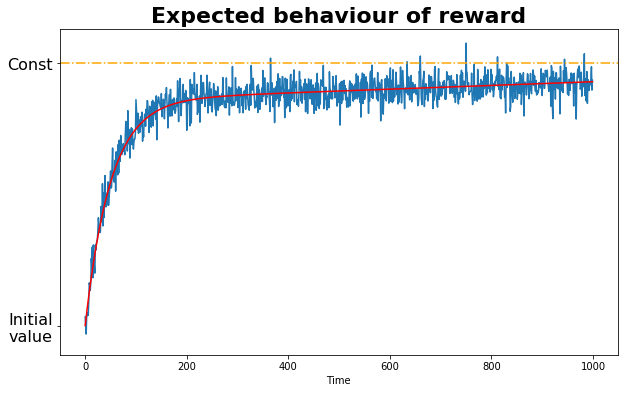

In [0]:
pyplot.figure(figsize=(10,6))
ax = pyplot.gca()
ax.plot(fake_reward)
ax.plot(fake_reward_mean,"r-")
ax.axhline(y = 1.1, color="orange", linestyle="-.")

ax.get_yaxis().set_tick_params(direction='out')
ax.yaxis.set_ticks_position('left')
ax.set_yticks([fake_reward_mean[0],1.1])
ax.set_yticklabels(["Initial\nvalue","Const"],fontsize=16)
ax.set_ylim(bottom = 0.8*fake_reward_mean[0], )
ax.set_xlabel("Time",fontsize=10)
ax.set_title("Expected behaviour of reward",fontsize=22,fontweight="bold");

In [0]:
fake_regret_mean = 1-fake_reward_mean + 0.08
fake_regret = fake_regret_mean + np.random.normal(0,0.03,size=(TIMESAMPLES,))
fake_regret = np.maximum(0, fake_regret)

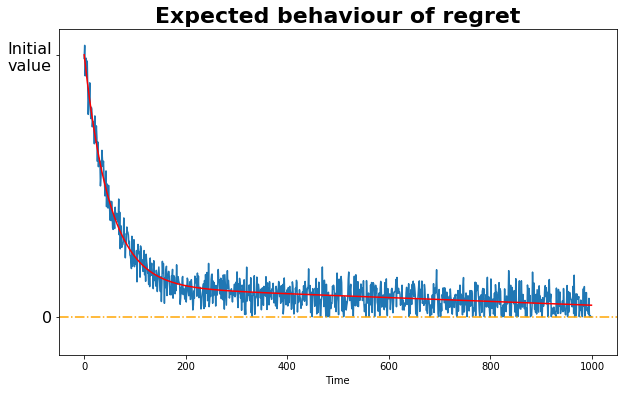

In [0]:
pyplot.figure(figsize=(10,6))
ax = pyplot.gca()
ax.plot(fake_regret)
ax.plot(fake_regret_mean,"r-")
ax.axhline(y = 0, color="orange", linestyle="-.")

ax.get_yaxis().set_tick_params(direction='out')
ax.yaxis.set_ticks_position('left')
ax.set_yticks([fake_regret_mean[0],0])
ax.set_yticklabels(["Initial\nvalue","0"],fontsize=16)
ax.set_ylim(top = 1.1*fake_regret_mean[0], bottom=-0.1)
ax.set_xlabel("Time")
ax.set_title("Expected behaviour of regret",fontsize=22,fontweight="bold");

## UCB and Boltzmann Exploration

In this section there is two realization of agents: UCB and Boltzmann agents.

UCB agent (according to Upper Confidence Bound Algorithm) stores averaged rewards (`values` in our implementation) and chooses action as following:

$$
Action_t = \underset{a \in A}{argmax} \, Q^a_t + C \, \sqrt{log \frac{t}{N^a_t}},
$$

where $Q^a_t$ is averaged reward for arm and $N^a_t$ is number of time arm was choosen.

Update of averaged rewards is online:

$$
Q^a_{t+1} = Q^a_t +  \frac{Reward_t - Q^a_t}{N^a_{t+1}}.
$$


In [0]:
class UCBAlgorithm(BanditAlgorithm):
    def __init__(self, num_arms=10, C=1, seed=None):
        super(UCBAlgorithm,self).__init__(num_arms,seed)
        self.C = C
        self.current_time = None
        self.reset()
    
    def _reset(self):
        self.current_time = 1
        self.num_taken += 1
    
    def _proba(self):
        # softmax is used to make a distribution for non-greedy experiment
        return softmax(self.values + self.C*np.sqrt(np.log(self.current_time)/self.num_taken))
       
    def update(self,action,reward):
        self.current_time += 1
        self.num_taken[action] +=1
        self.values[action] += (reward-self.values[action])/self.num_taken[action]

Boltzmann agent stores perferences (`values` in the implementation) directly and uses `Softmax` function to turn them into a probability distribution.

$$
Softmax(x) = \frac{\exp(x_i)}{\displaystyle\sum_{i=1}^N \exp(x_i)}.
$$

Update of preferences:
$$
H^a_{t+1} = H^a_t + \alpha \left( Reward_t - Q^a_{t+1} \right) (\mathbb{I}_{a =Action_t} - Softmax(H_t)).
$$

Averaged rewards computed as online average:
$$
Q^a_{t+1} = \frac{N^a_{t+1} -1}{N^a_{t+1}}Q^a_t + \frac{R_t}{N^a_{t+1}}.
$$

In [0]:
class BoltzmannExplorationAlgorithm(BanditAlgorithm):
    def __init__(self,num_arms=10,learning_rate=1e-3, seed=None):
        super(BoltzmannExplorationAlgorithm,self).__init__(num_arms,seed)
        self.learning_rate = learning_rate
        self.reward_averages = None
        self.reset()
    
    def _reset(self):
        self.reward_averages = np.zeros((self.num_arms,))
    
    def _proba(self):
        # softmax is used to turn preferences into distribution
        return softmax(self.values)
    
    def update(self,action,reward):
        self.num_taken[action] +=1
        self.reward_averages[action] = (self.num_taken[action]-1)*self.reward_averages[action]/self.num_taken[action] +\
                    reward/self.num_taken[action]

        mask = np.zeros((self.num_arms,))
        mask[action] = 1
        self.values += self.learning_rate * (reward - self.reward_averages) * (mask - self._proba())

##Experiments with Multi Armed Bandit Normal

Finally, after all those preparations. We beginning to start! With experiments!

First things first, lets define a couple of thing called builders. As you may remember from the from of Testing framework section to run experiment we need something that consumes seed and produces a brand new instance of environment or algorithm.

In [0]:
environment_builder = lambda s: MultiNormalArmBandit(NUMBER_OF_ARMS,TIMESAMPLES,seed=s)

baseline_builder = lambda s: RandomAlgorithm(seed=s)

### Baseline

It is not possible to specify dreedy stratedy for baseline.

Trial 10 of 10


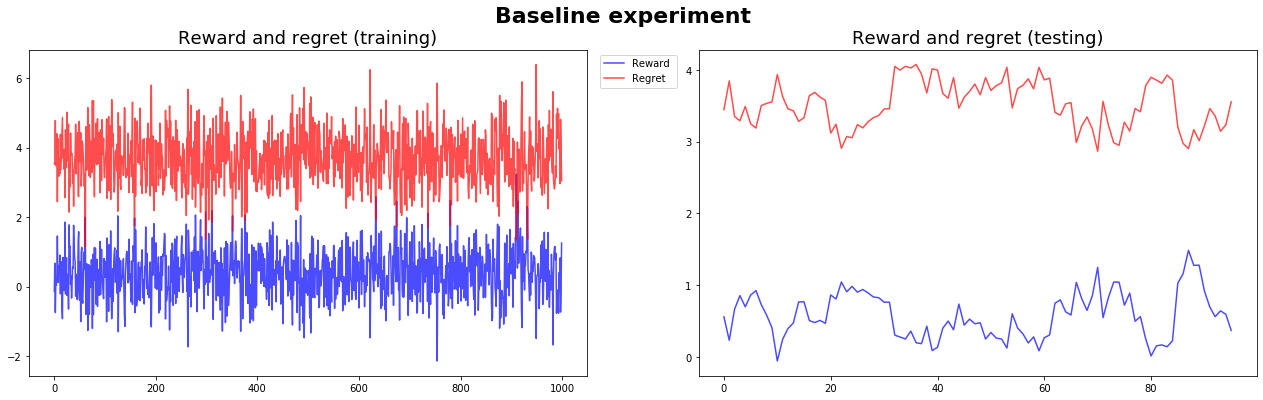

In [0]:
reward, regret, mawged_r, mawged_reg = run_experiment(environment_builder, baseline_builder,RUNS_TO_AVERAGE,masterseed=SEED,greedy=False)
plot_results((reward, regret, mawged_r, mawged_reg),"Baseline experiment")

Regret is high, return is low. That's what you get after plaing a slots machine.
Also they are stationary, because it never learns. 

This result is our baseline to see any improvements.

### UCB 

Next speciment is UCB agent.

We hope it would be better than baseline.

In this experiment we will try to tune `C` parameter of UCB.

As you probably remember, our framework allows to either sample action or choose maximum in respect ot probability, so for all experiments there will be two cases: sampling and greedy.


In [0]:
def ucb_experiment_helper(environment_builder,parameter):
    # Just a little helper to make life easier
    # Don't you mind and proceed to experiments
    ucb_builder = lambda s: UCBAlgorithm(NUMBER_OF_ARMS,C=parameter,seed=s)

    res = run_experiment(environment_builder, ucb_builder,RUNS_TO_AVERAGE,masterseed=SEED,greedy=True)
    plot_results(res,f"UCB experiment (C={parameter}) Greedy")
    res = run_experiment(environment_builder, ucb_builder,RUNS_TO_AVERAGE,masterseed=SEED,greedy=False)
    plot_results(res,f"UCB experiment (C={parameter}) Sampling")


Trial 10 of 10
Trial 10 of 10


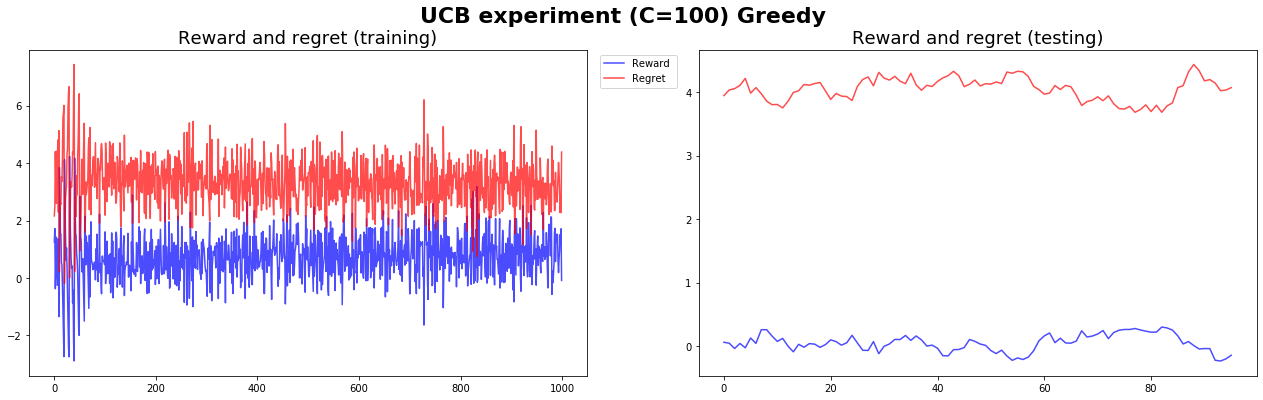

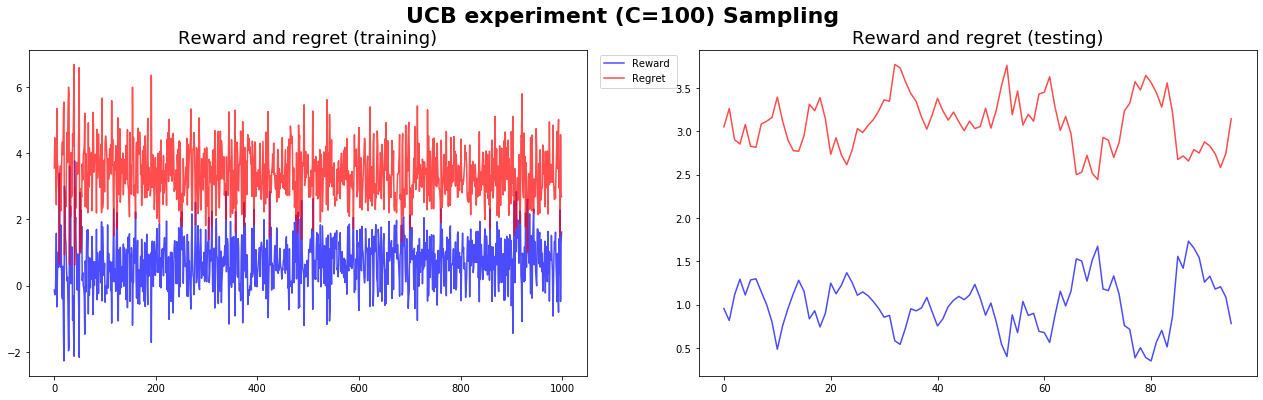

In [0]:
# let's start with C=100, just because we can
# we call it an extremal case
ucb_experiment_helper(environment_builder,100)

Trial 10 of 10
Trial 10 of 10


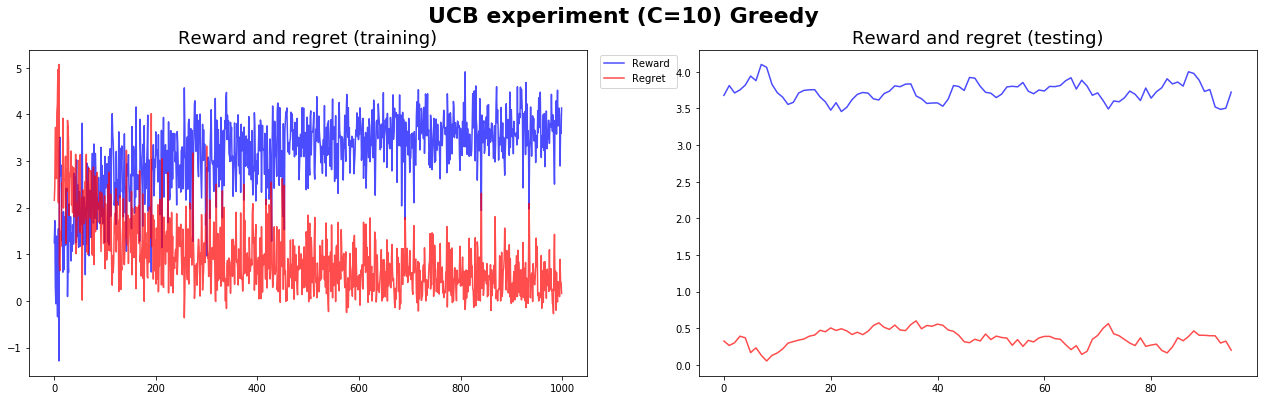

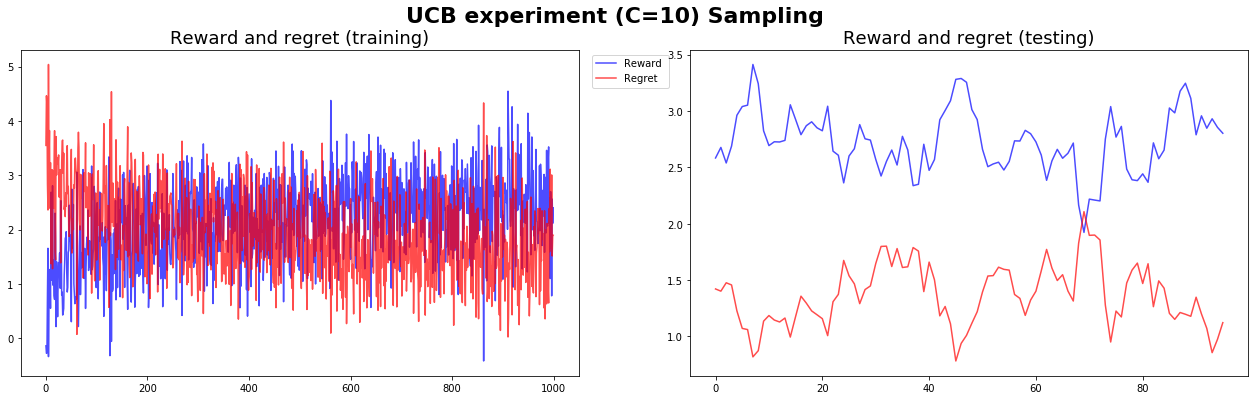

In [0]:
ucb_experiment_helper(environment_builder,10)

Trial 10 of 10
Trial 10 of 10


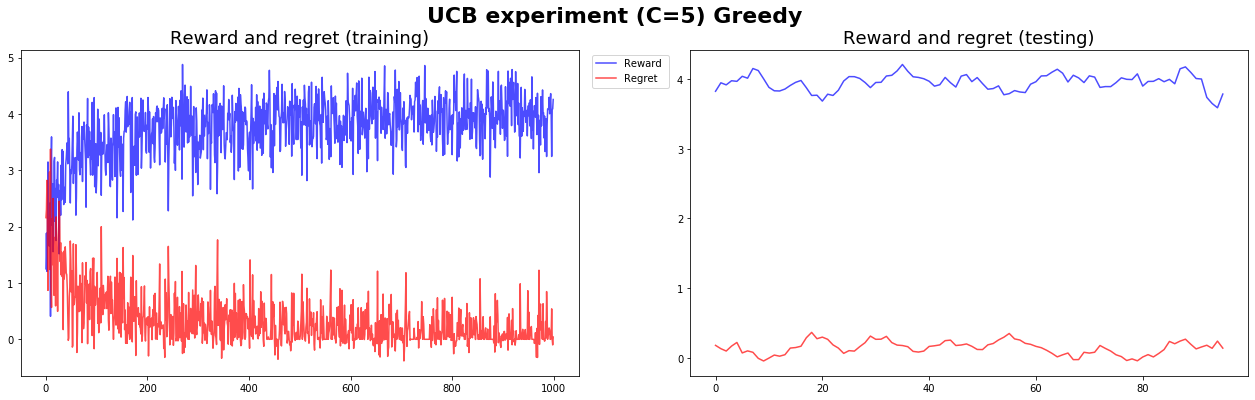

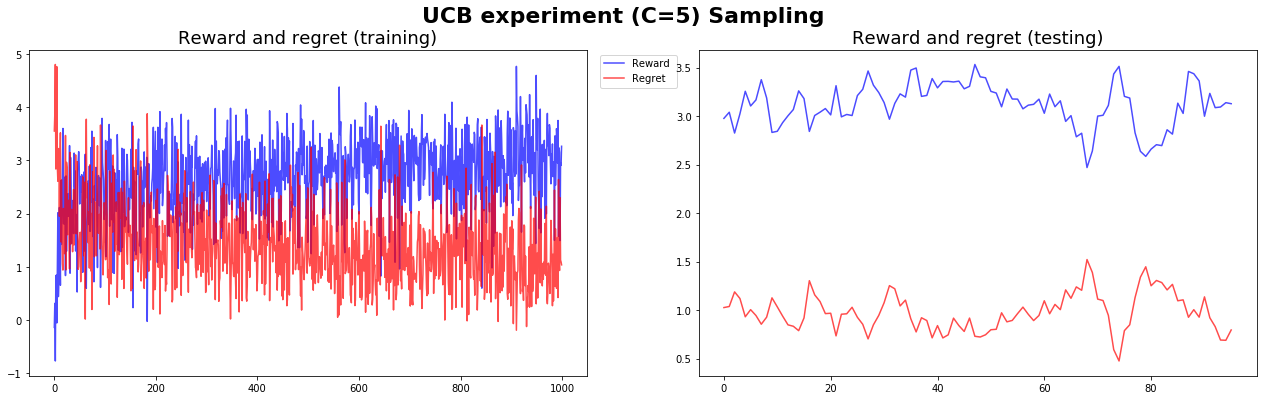

In [0]:
ucb_experiment_helper(environment_builder,5)

Trial 10 of 10
Trial 10 of 10


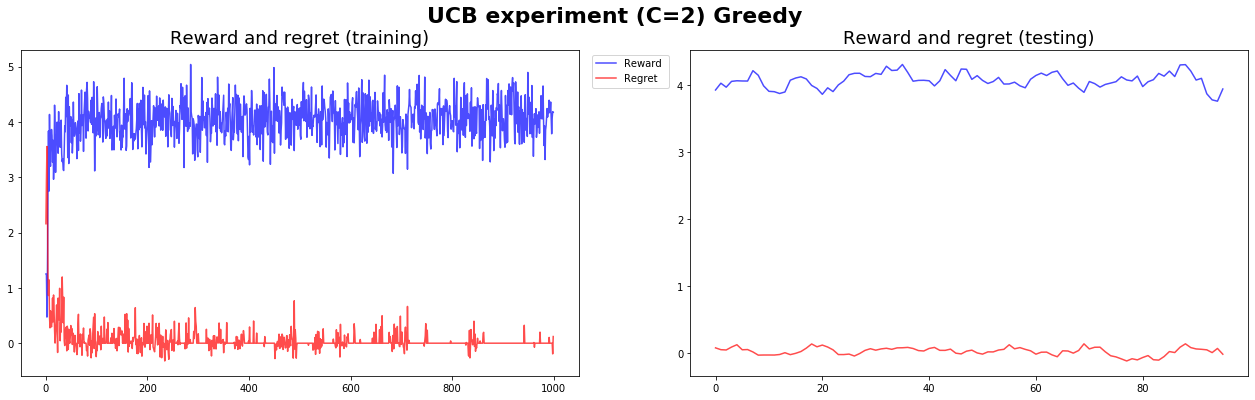

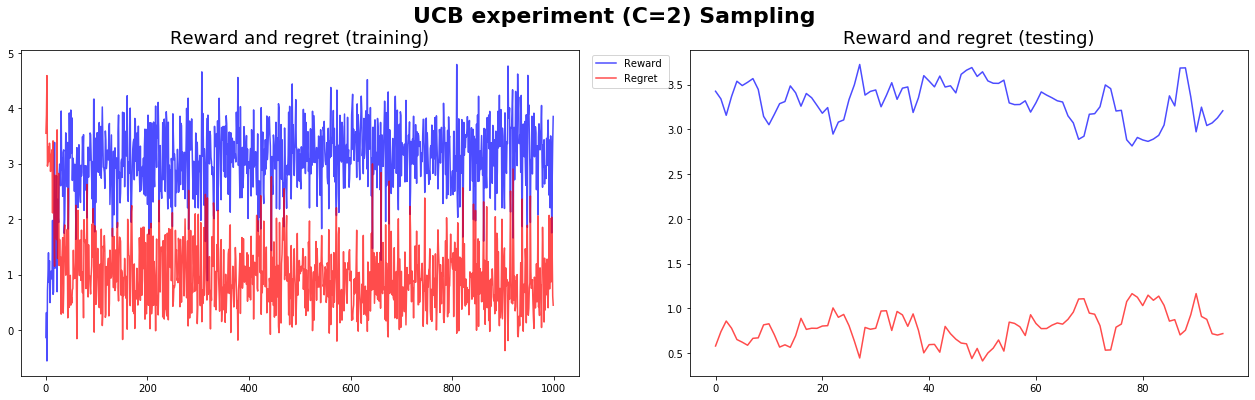

In [0]:
ucb_experiment_helper(environment_builder,2)

Trial 10 of 10
Trial 10 of 10


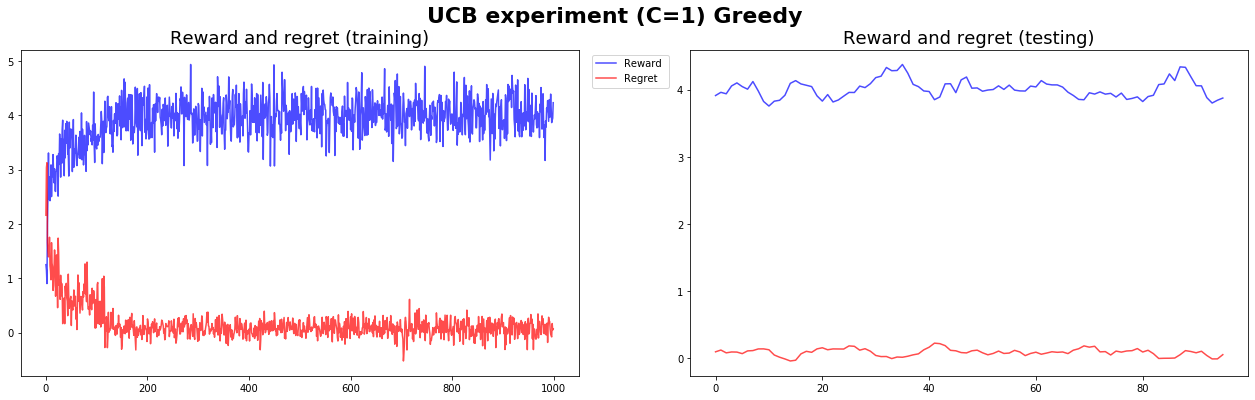

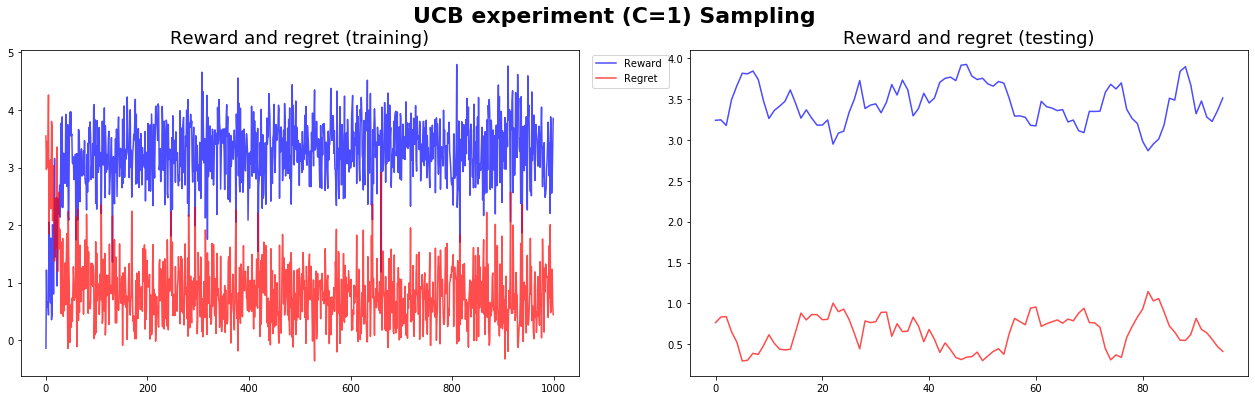

In [0]:
ucb_experiment_helper(environment_builder,1)

Trial 10 of 10
Trial 10 of 10


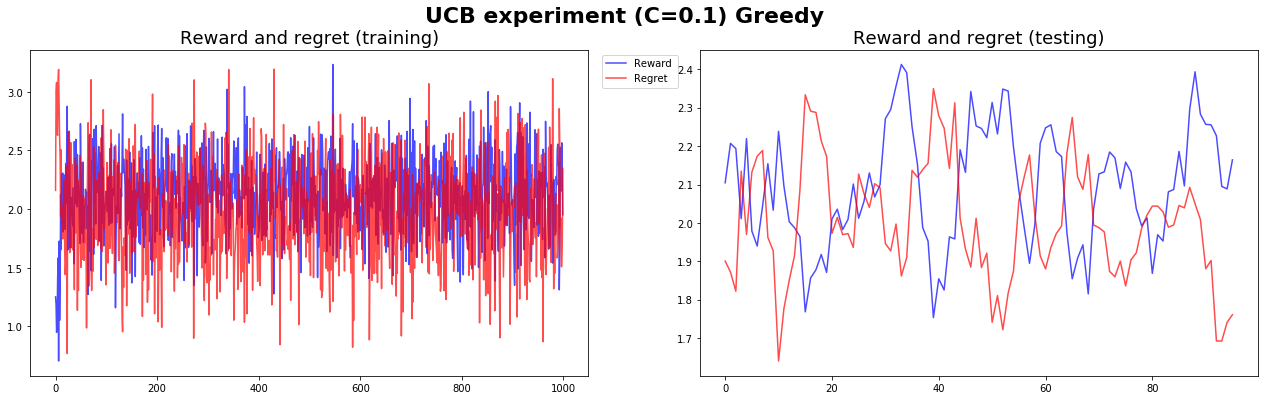

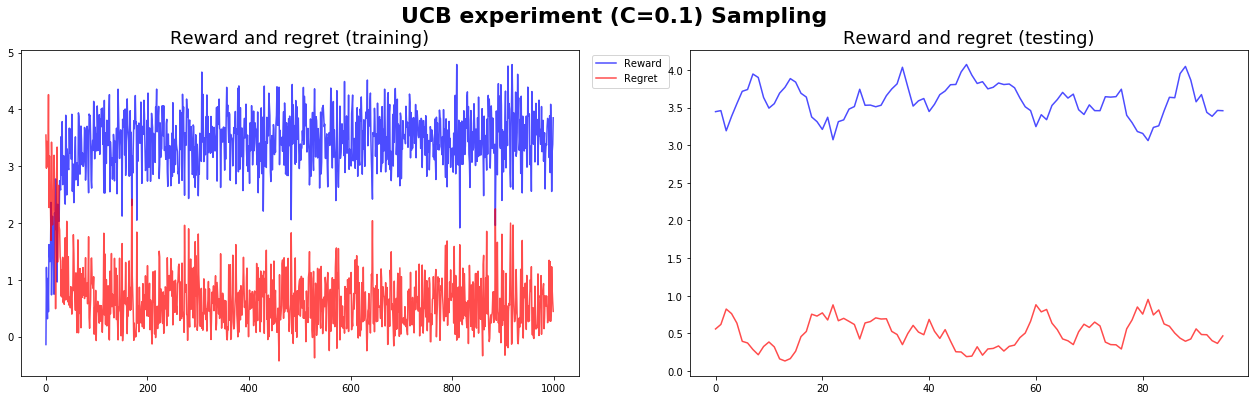

In [0]:
# another extremal case
ucb_experiment_helper(environment_builder,0.1)

In this experiment we tested `C={100, 10, 5, 2, 1, 0.1}` where first and the last one are treated as extremal cases.

Generally speeking greedy strategy works better in sence that sampling produces more noisy results.

The best results is obtained with greedy stratedy and C=2 (look at the regret plot).

Now let's look at extremal cases. \\
At `C=100` greedy action failed as well as sampling, their behaviour is simalr to baseline. This value is too big. 
At `C=0.1` greedy stratedy seems fail to learn, while sampling still achieve  some results.



### Boltzman Exploration

In this experiment we are going to look at the behaviour Boltzman Exploration agent  with differend `learning_rate` parameter. Experiments is with the same environment.

In [0]:
def boltzman_experiment_helper(environment_builder,parameter):
    # Another little helper
    # And again, nothing interesting here
    ucb_builder = lambda s: BoltzmannExplorationAlgorithm(NUMBER_OF_ARMS,learning_rate=parameter,seed=s)

    res = run_experiment(environment_builder, ucb_builder,RUNS_TO_AVERAGE,masterseed=SEED,greedy=True)
    plot_results(res,f"Boltzmann Exploration experiment (LR={parameter}) Greedy")
    res = run_experiment(environment_builder, ucb_builder,RUNS_TO_AVERAGE,masterseed=SEED,greedy=False)
    plot_results(res,f"Boltzmann Exploration  experiment (LR={parameter}) Sampling")


Trial 10 of 10
Trial 10 of 10


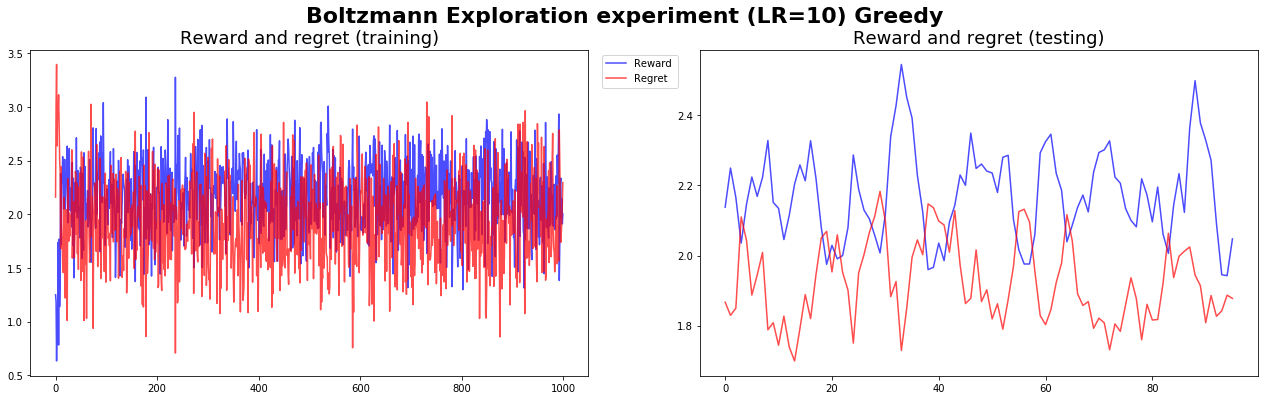

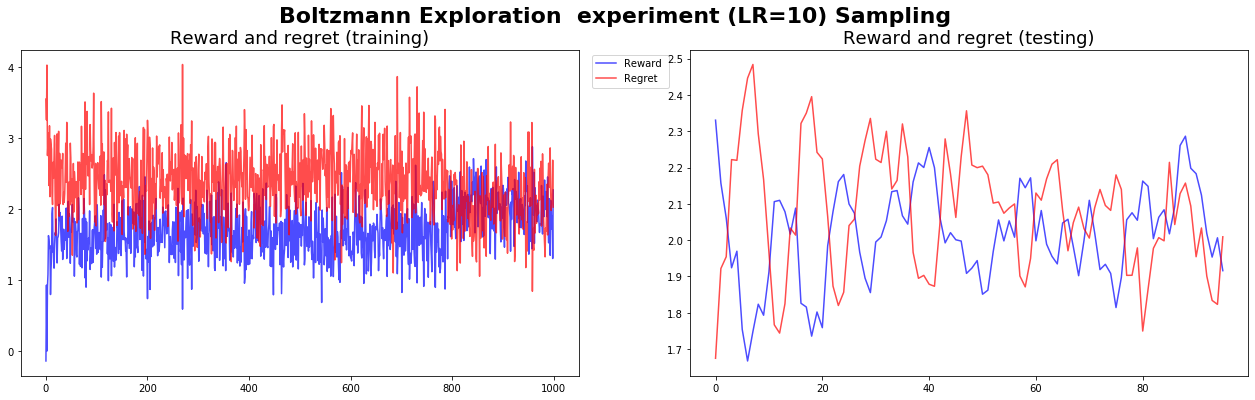

In [0]:
boltzman_experiment_helper(environment_builder,10)

Trial 10 of 10
Trial 10 of 10


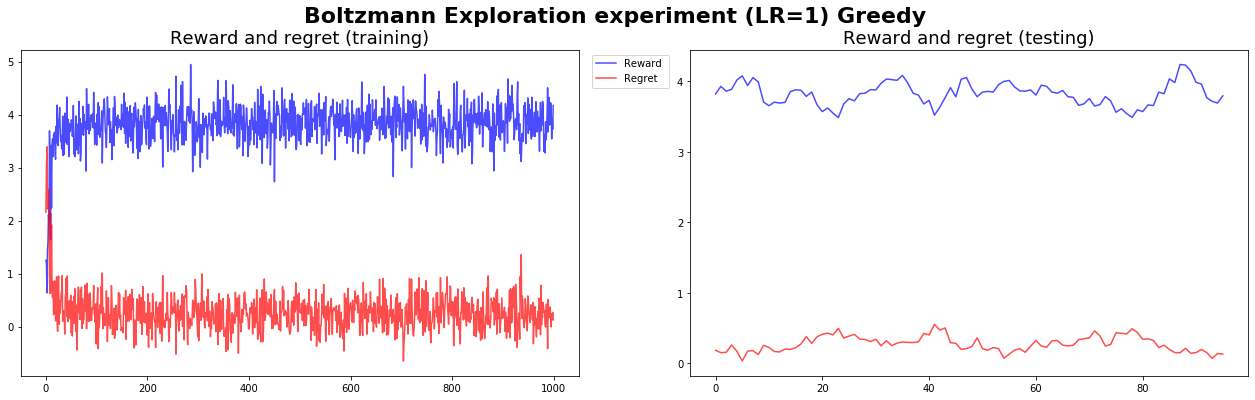

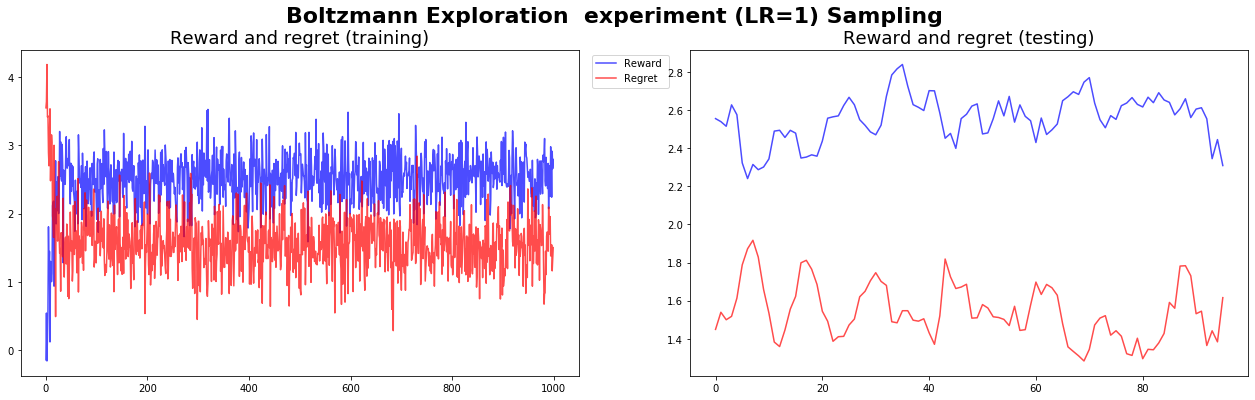

In [0]:
boltzman_experiment_helper(environment_builder,1)

Trial 10 of 10
Trial 10 of 10


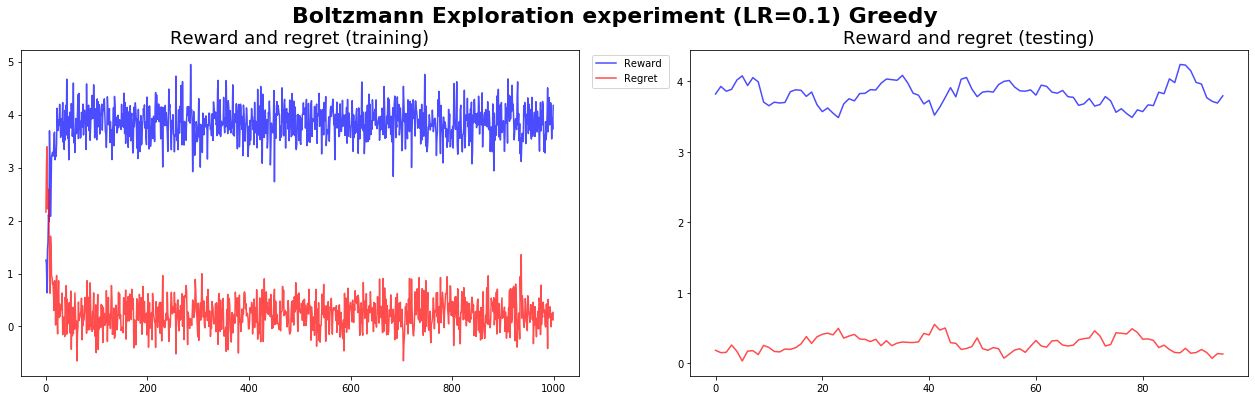

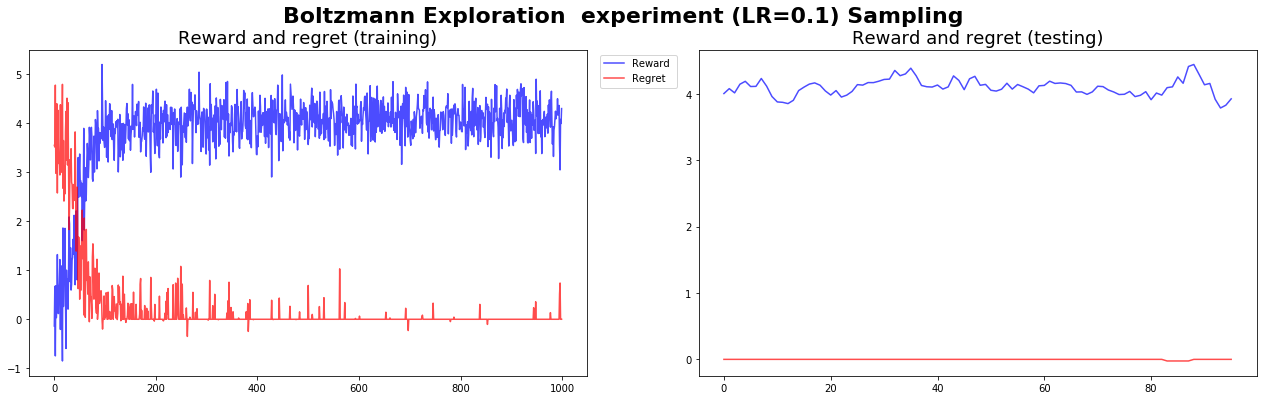

In [0]:
boltzman_experiment_helper(environment_builder,0.1)

Trial 10 of 10
Trial 10 of 10


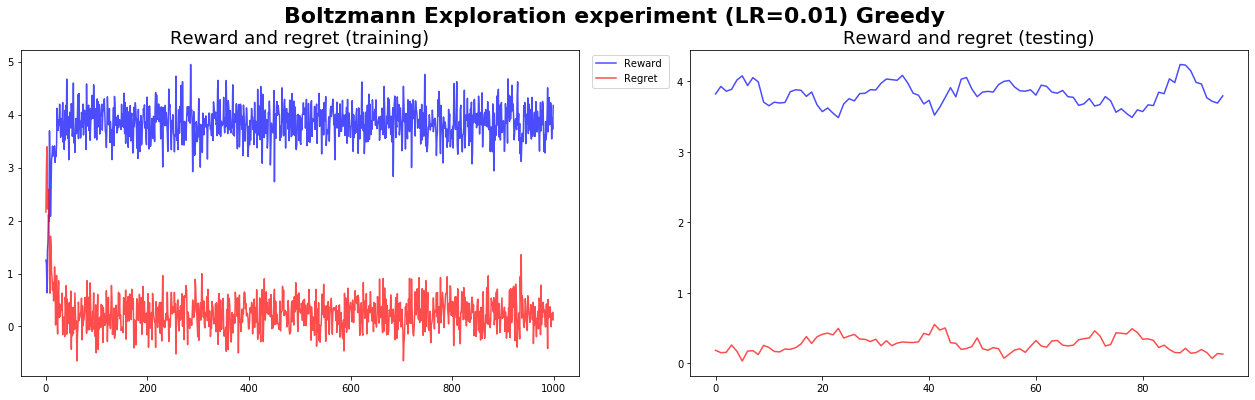

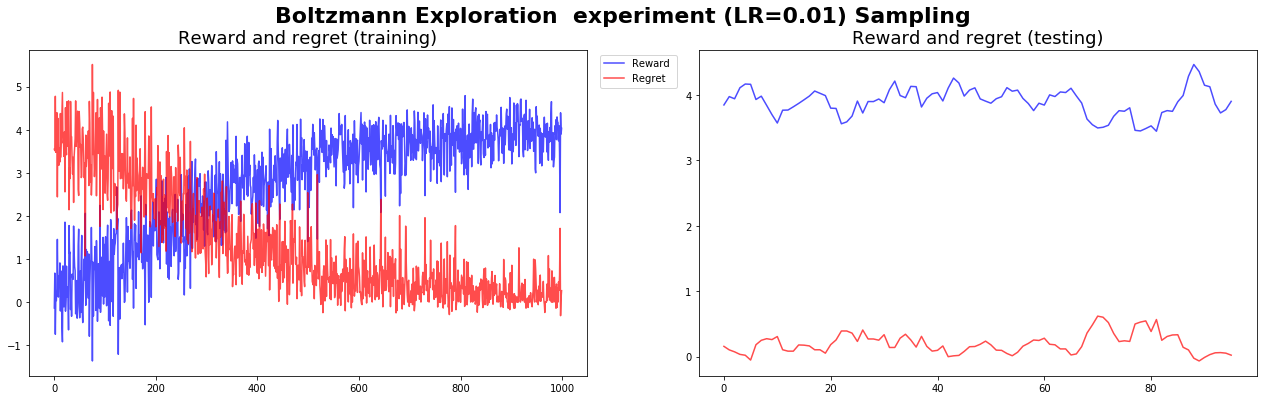

In [0]:
boltzman_experiment_helper(environment_builder,0.01)

Trial 10 of 10
Trial 10 of 10


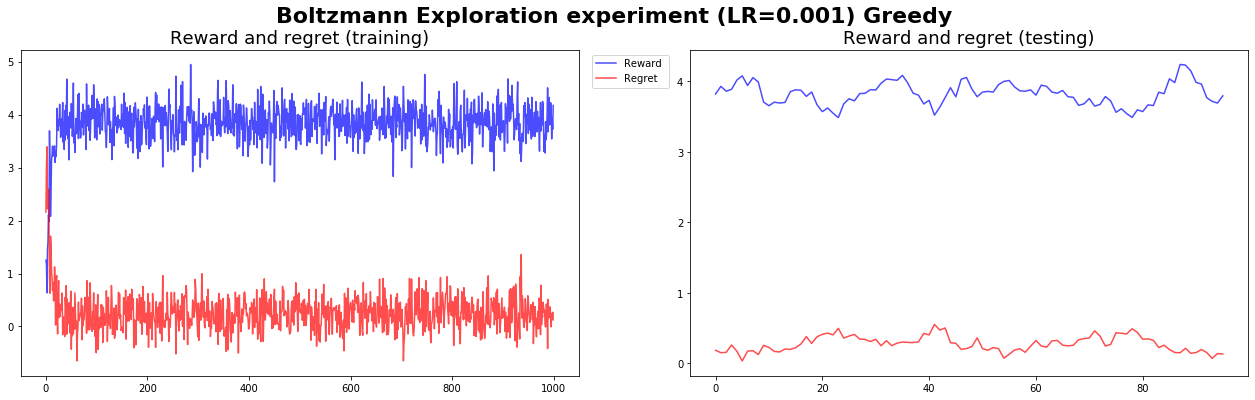

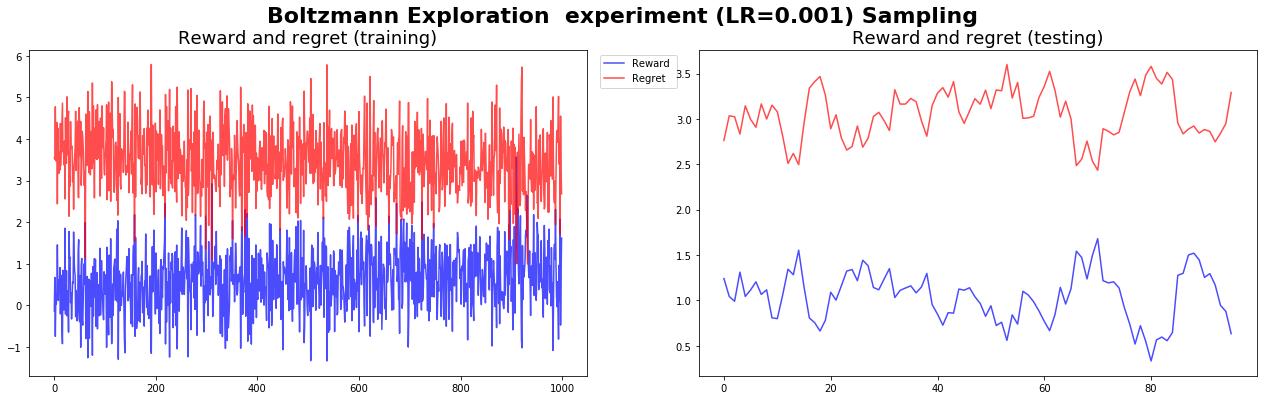

In [0]:
boltzman_experiment_helper(environment_builder,0.001)

In this experiment we tested `learning_rate={10,1,0.1,0.01,0.001}`, where first one is an extremal case.

In overall, with LR less than one greedy and sampling strategies archives approximately the same result. However, sampling strategy takes much longer update steps. For instance experiment with LR=0.001.

The best results is obtained with LR=0.1 and sampling strategy.

## Multi Armed Bandit Bernoulli

Let's try something else. For the reason that will be described in the next section we can not use previous environment in the further experiments.

Our new environment is a classical Bernoulli bandit. Rewards here are the samples from Bernoulli distribution. In this experiment it would be easier to see correlations with results from expected results section.

$$
\forall arm \in [1..10] \quad R^{arm}_{time} \sim \mathcal{Bernoulli}(p_{arm})\, \quad p_{arm} \sim \mathcal{U}[0,\,1]\,.
$$

In [0]:
class MultiBernoulliArmBandit(MultiArmBandit):
    def initalize_arms(self):
        self.probabilities = self.random_generator.uniform(0,1,size=self.n_arms)
        # Numpy does not have function to sample from bernoulli distribution
        # Do not panic! We can trick it with properly adjusted binomial. 
        self.rewards_array = [self.random_generator.binomial(n=1,p=self.probabilities[i],size=(self.max_timesteps,)) for i in range(self.n_arms)]
        self.rewards_array = np.vstack(self.rewards_array)
    
    def plot(self):
        labels = list(range(1,11))
        inds = np.arange(1, len(labels) + 1)
        
        pyplot.figure()
        ax = pyplot.gca()
        # We are using bar plot where bars are represented probabilities
        ax.bar(inds, np.mean(self.rewards_array,axis=1))

        ax.scatter(inds, self.probabilities, marker='x', color='k', s=30, zorder=3)

        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(inds)
        ax.set_xticklabels(labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        ax.set_xlabel('Actions')
        ax.set_ylabel("Probability of success")
    
    def get_best_arm(self):
        return np.argmax(self.probabilities)

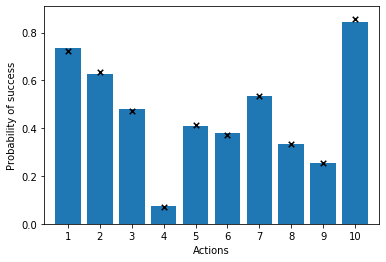

In [0]:
mbab = MultiBernoulliArmBandit(NUMBER_OF_ARMS,TIMESAMPLES)
mbab.plot()

## Tompson Sampling

Tompson Sampling agent is slightly differend fromalgorithm we have already seen above.

$$
Action_t = \underset{a \in A}{argmax} \, \theta^a_t\,,
$$
where $\theta^a_t \sim  B(\alpha_t^a,\beta^a_t)$.

Tomplon sampling is natuallu stochastic and require to store parameters of beta distribution (in the implementation we use `values` and `num_taken` respectively).

Update of parameters:

$$
\alpha_{t+1}^a = \alpha_{t}^a + Reward_t\,,
$$

$$
\beta_{t+1}^a = \beta_{t}^a + 1- Reward_t\,,
$$
where $a = Action_t$.

In [0]:
class TompsonSamplingAlgorithm(BanditAlgorithm):
    def __init__(self,num_arms=10, seed=None):
        super(TompsonSamplingAlgorithm,self).__init__(num_arms,seed)

    def _reset(self):
        self.values += 1
        self.num_taken += 1

    def _proba(self):
        thetas = [self.random_generator.beta(self.values[i], self.num_taken[i]) for i in range(self.num_arms)]
        return softmax(thetas)
         
    def update(self,action,reward):
        self.values[action] += reward
        self.num_taken[action] += 1 - reward


## Experiments with Multi Arm Bandit Bernoulli

Here we are again in the experiment section.

In this section we are going to have series of experiments with Bernoulli environment.

In [0]:
# defining new builder...
environment_builder = lambda s: MultiBernoulliArmBandit(NUMBER_OF_ARMS,TIMESAMPLES,seed=s)

### Baseline

Trial 10 of 10


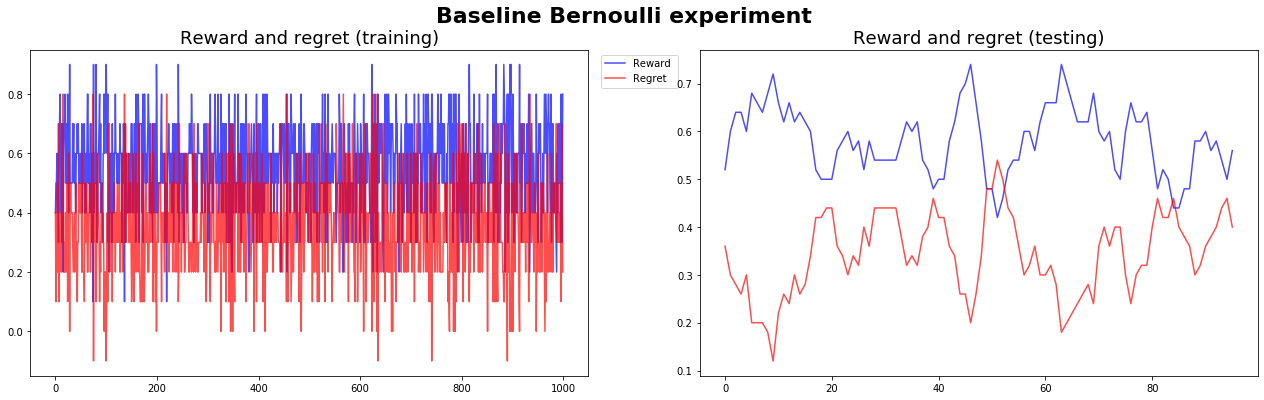

In [0]:
res = run_experiment(environment_builder, baseline_builder,RUNS_TO_AVERAGE,masterseed=SEED,greedy=False)
plot_results(res,"Baseline Bernoulli experiment")

In the baseline experiment reward is slightly bigger than regret for the unknown reason.
I presume this is a statistical fluctuation since both plots bouncing near 0.5 which is reasonable.

### UCB

For the new environment we repeat the same series of experiments as last time.

Trial 10 of 10
Trial 10 of 10


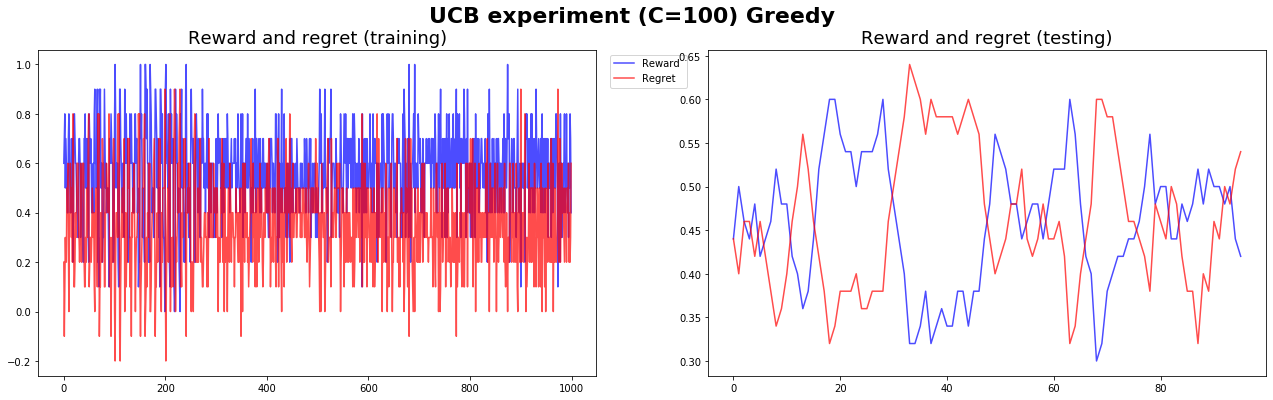

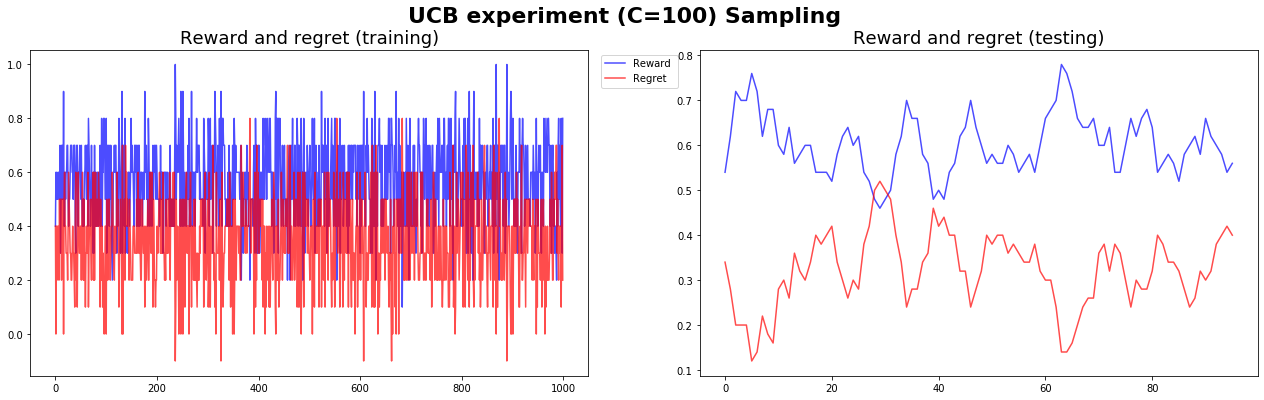

In [0]:
# we use the same helper as in previous experiments.
# But keep in mind that now we reffering to another environment.
ucb_experiment_helper(environment_builder,100)

Trial 10 of 10
Trial 10 of 10


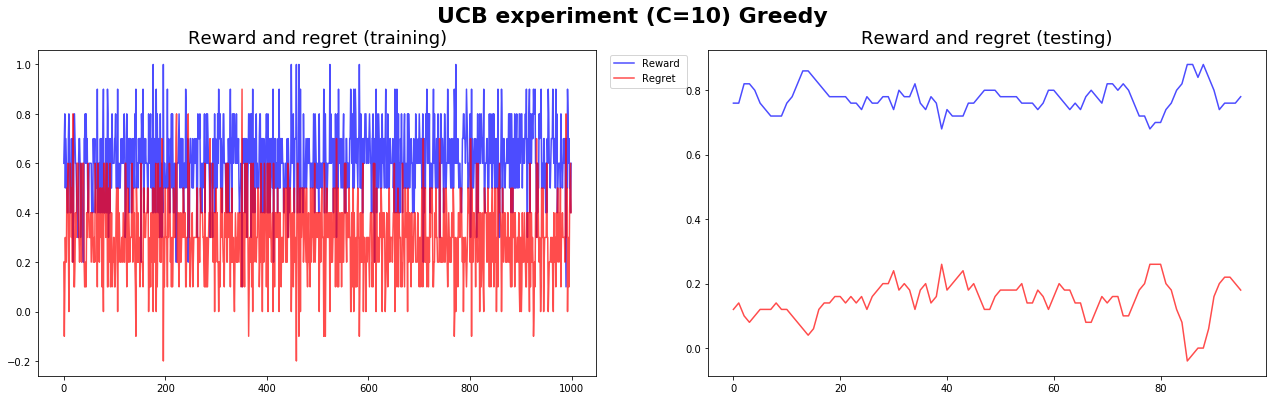

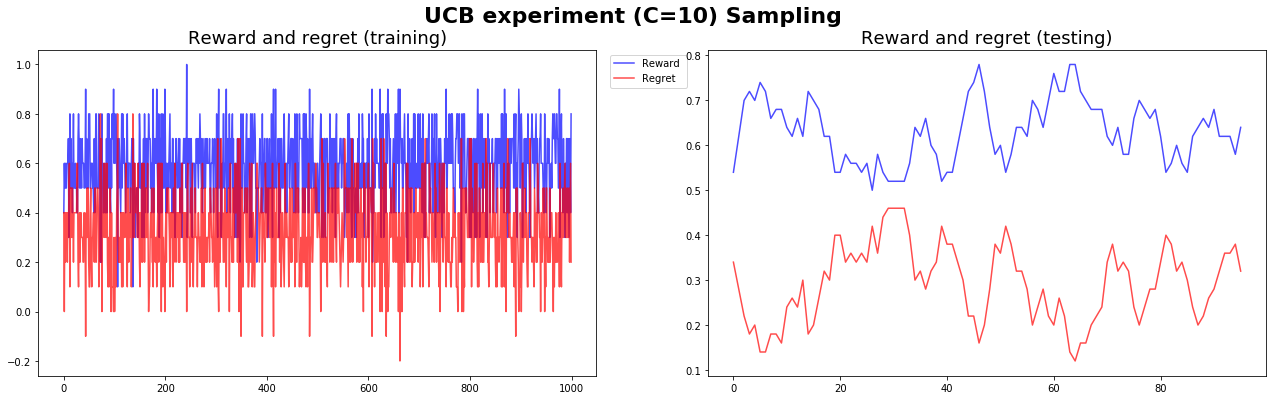

In [0]:
ucb_experiment_helper(environment_builder,10)

Trial 10 of 10
Trial 10 of 10


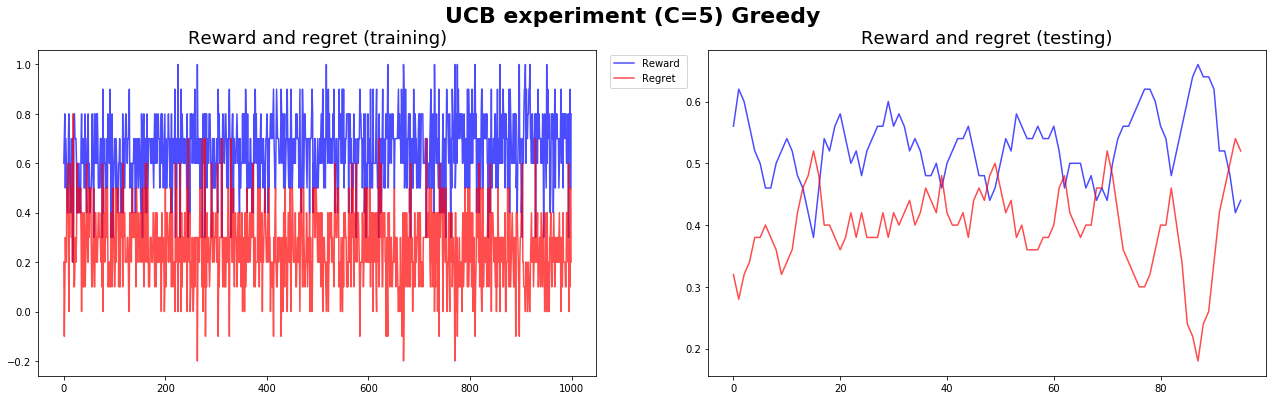

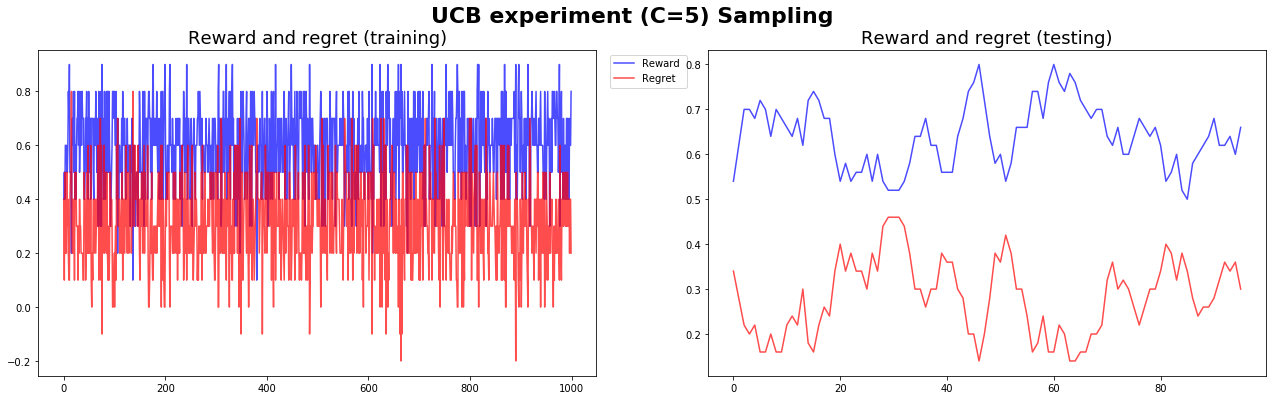

In [0]:
ucb_experiment_helper(environment_builder,5)

Trial 10 of 10
Trial 10 of 10


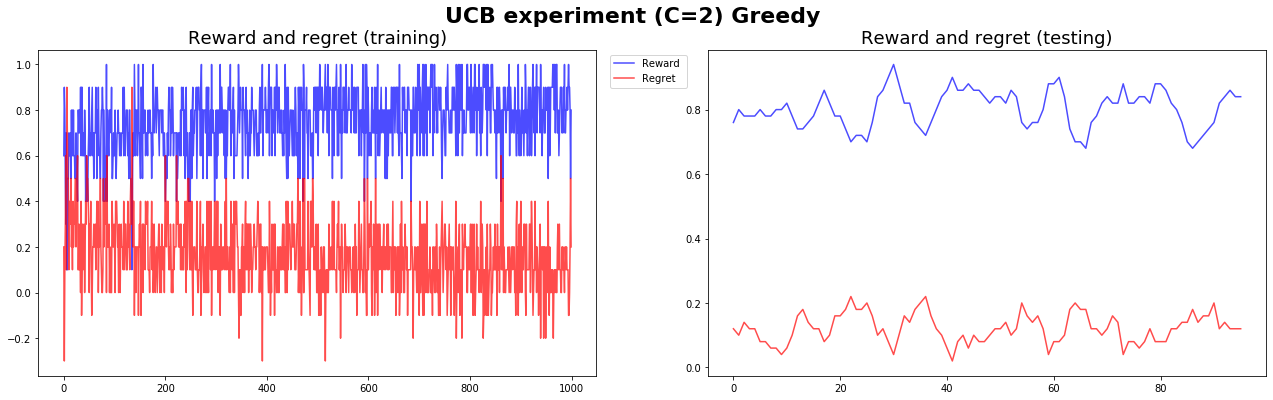

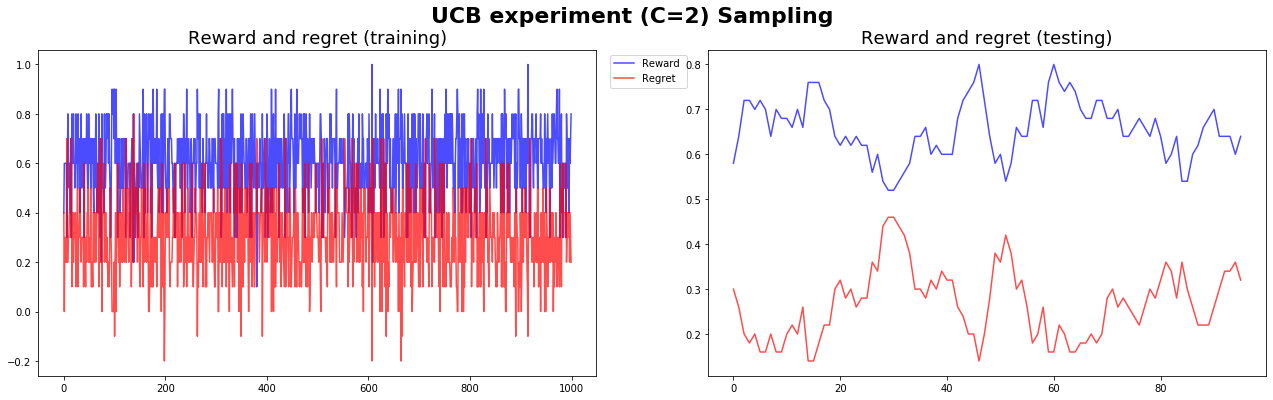

In [0]:
ucb_experiment_helper(environment_builder,2)

Trial 10 of 10
Trial 10 of 10


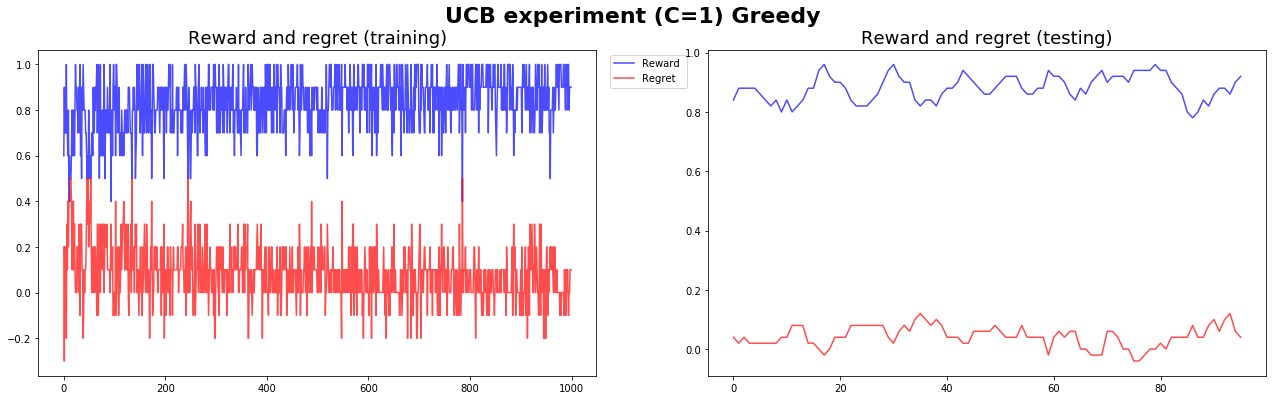

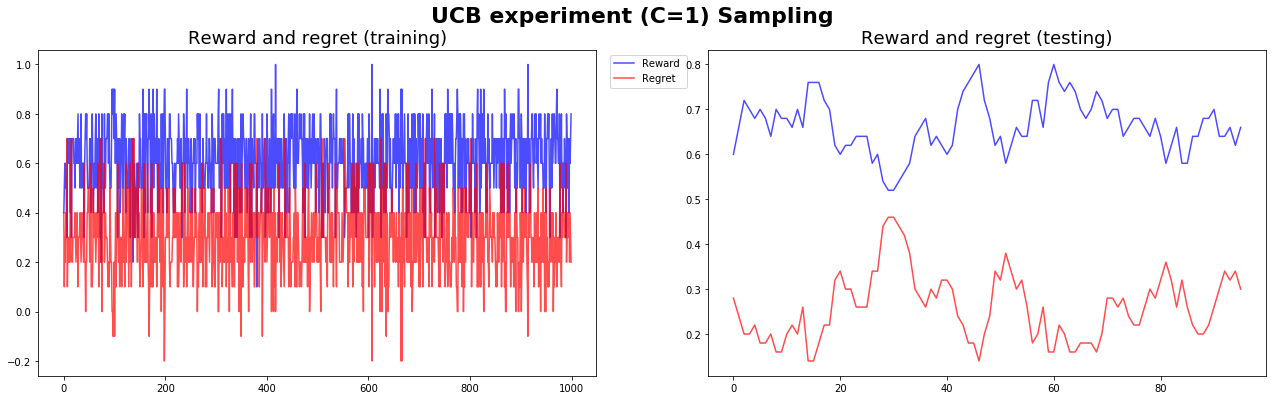

In [0]:
ucb_experiment_helper(environment_builder,1)

Trial 10 of 10
Trial 10 of 10


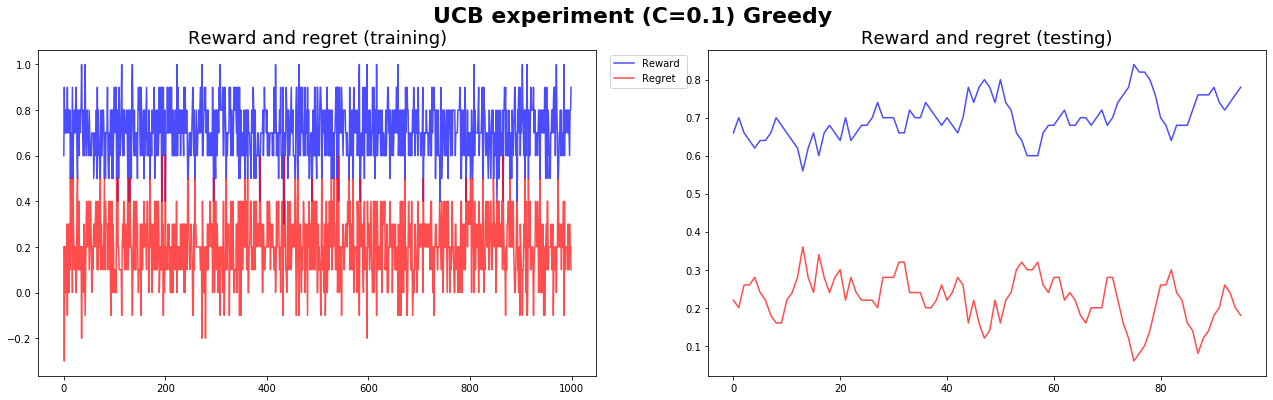

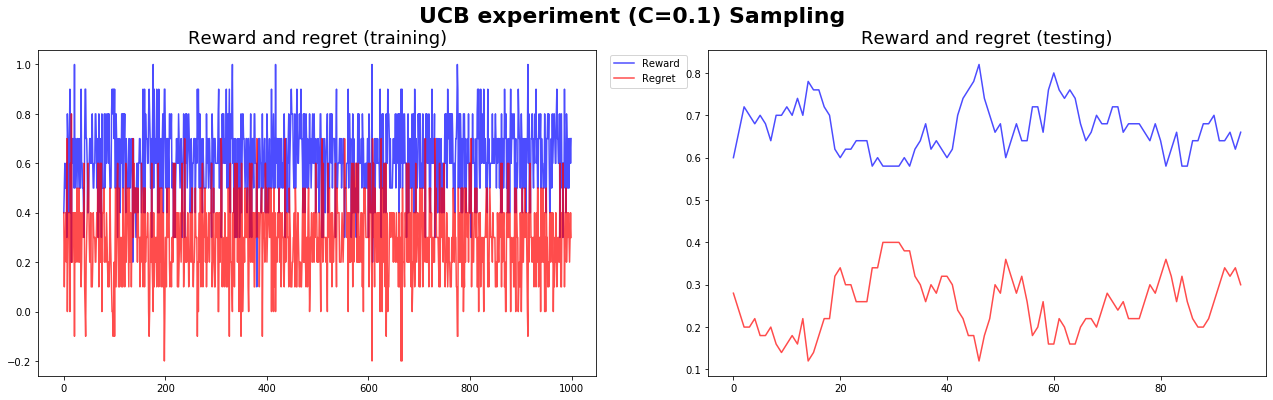

In [0]:
ucb_experiment_helper(environment_builder,0.1)

In the Bernoulli environment sampling strategy works worse than greedy in overall. Lower `C` produces more effective results.

The best result were obtained with `C=1`.

The extremal case `C=100` seems similar to baseline. While `C=0.1` is not an extremal case for this environment.

### Boltzman Exploration

Repeating experiments with new environment.

Trial 10 of 10
Trial 10 of 10


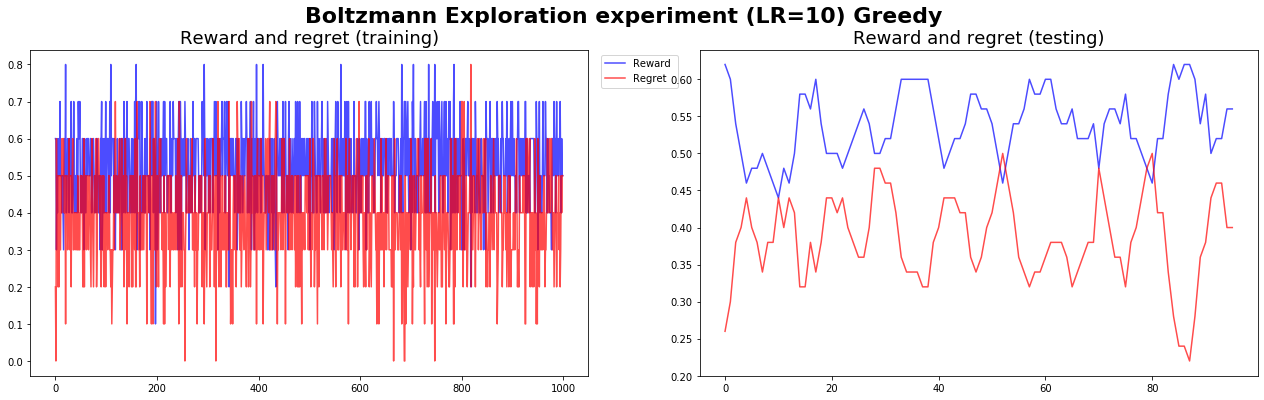

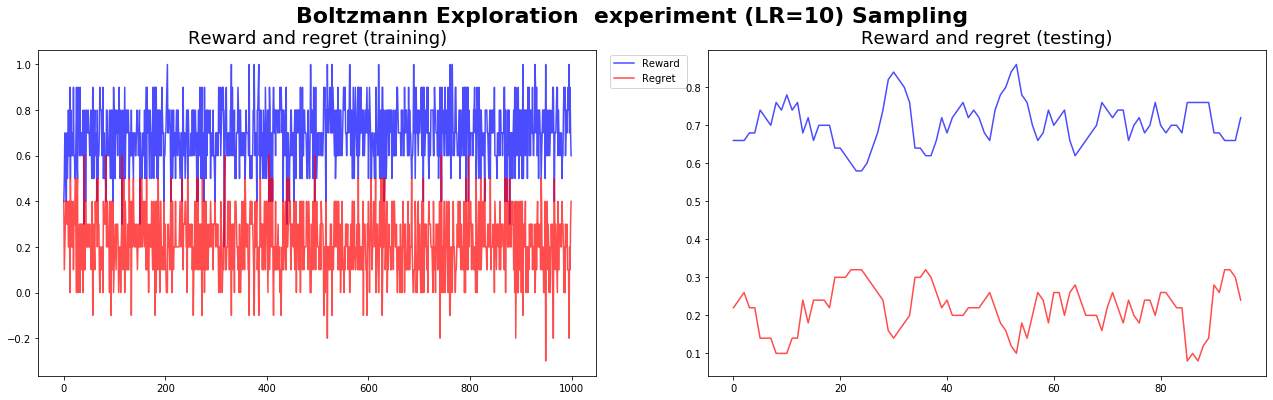

In [0]:
boltzman_experiment_helper(environment_builder,10)

Trial 10 of 10
Trial 10 of 10


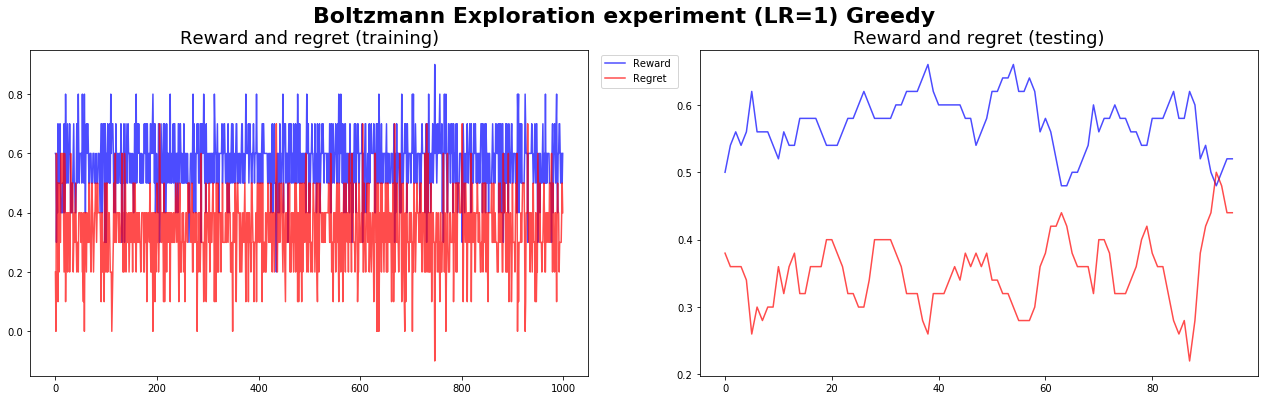

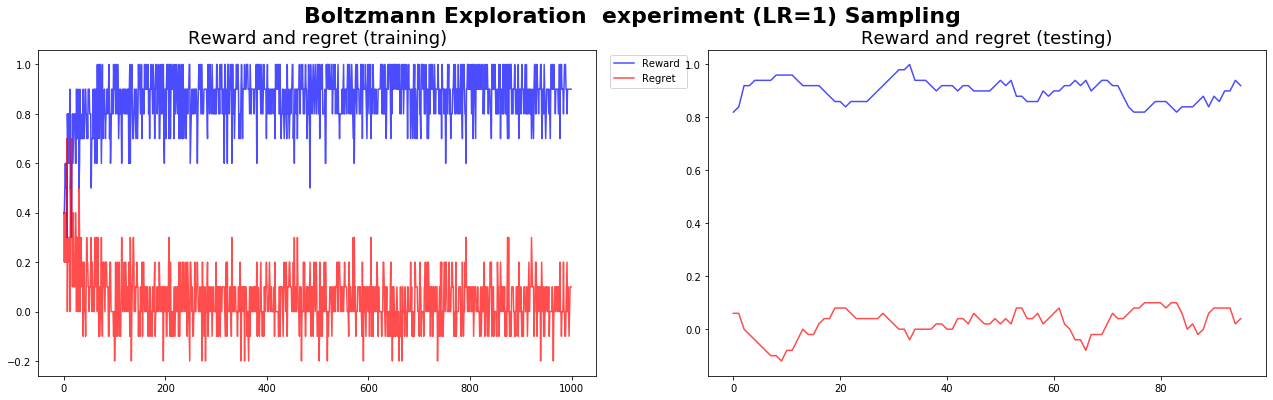

In [0]:
boltzman_experiment_helper(environment_builder,1)

Trial 10 of 10
Trial 10 of 10


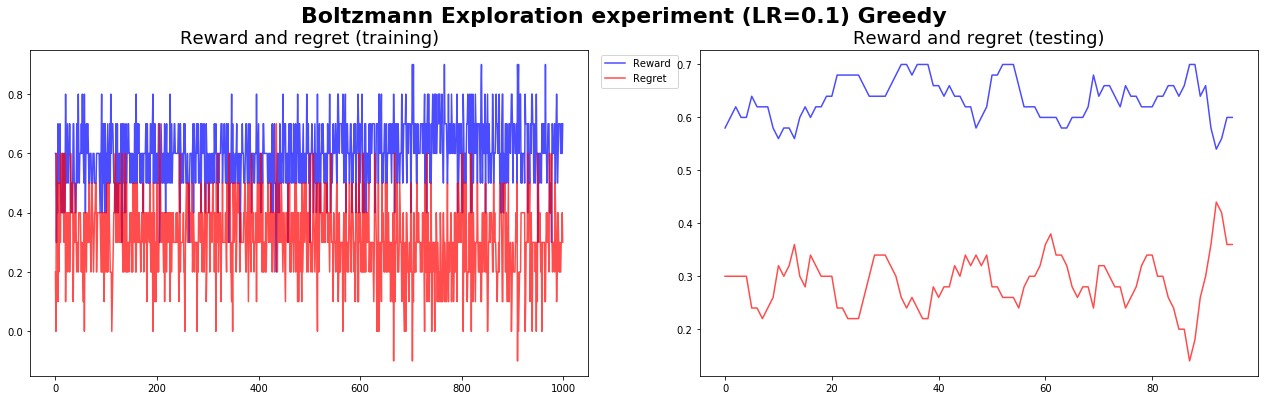

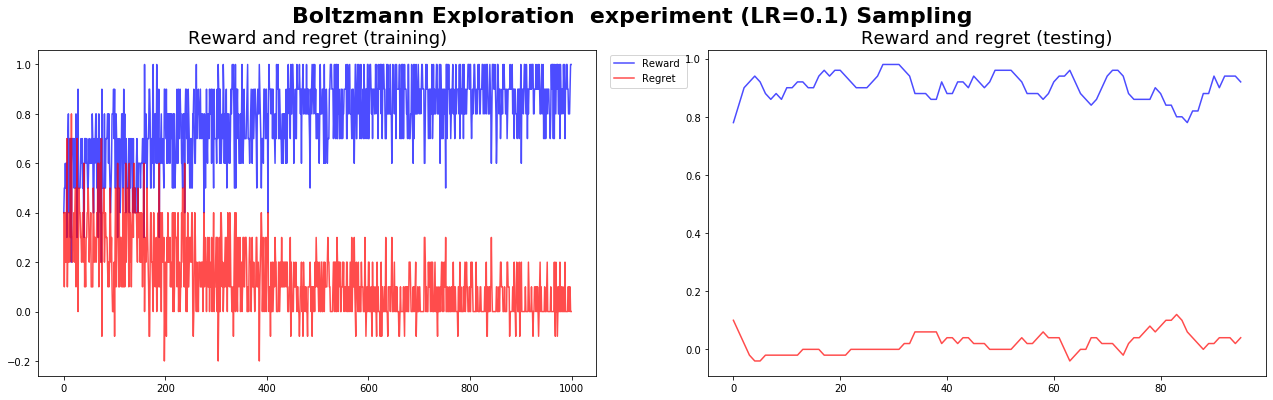

In [0]:
boltzman_experiment_helper(environment_builder,0.1)

Trial 10 of 10
Trial 10 of 10


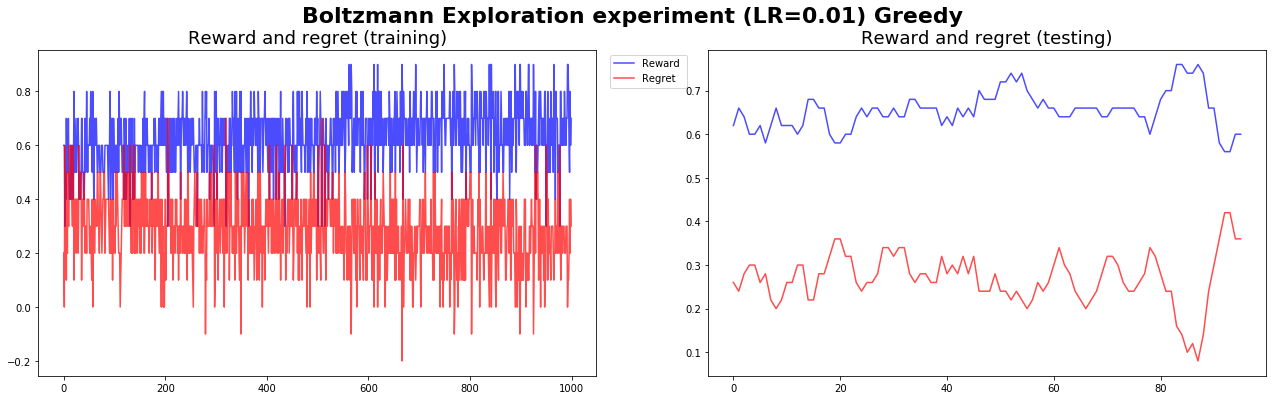

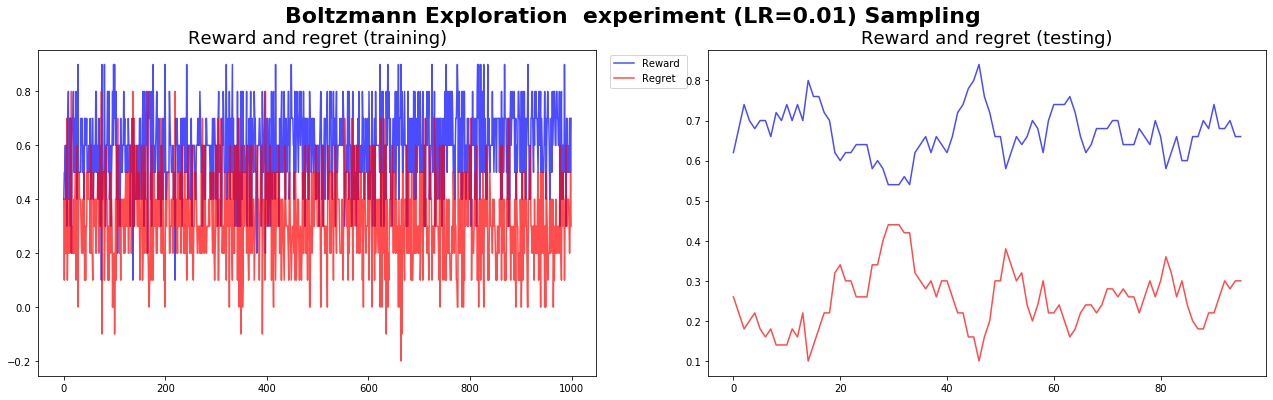

In [0]:
boltzman_experiment_helper(environment_builder,0.01)

Trial 10 of 10
Trial 10 of 10


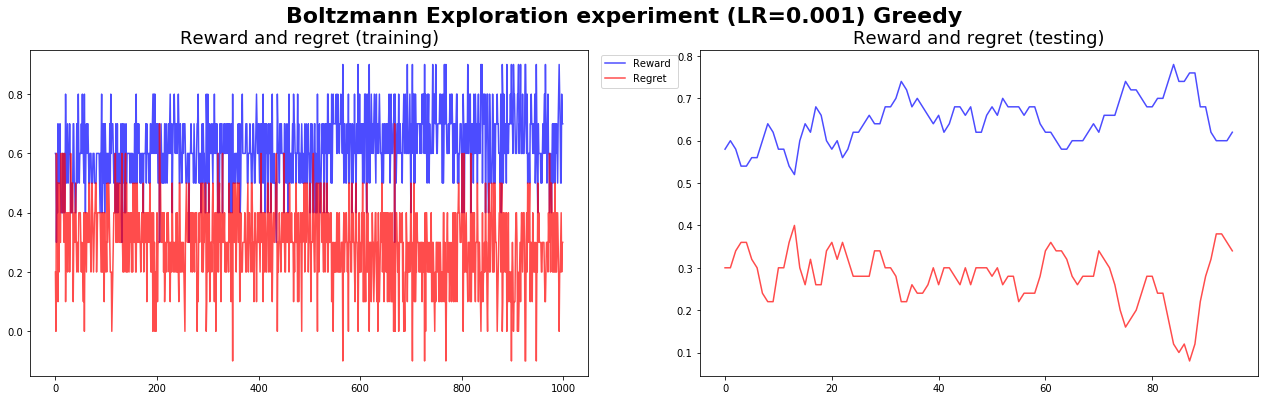

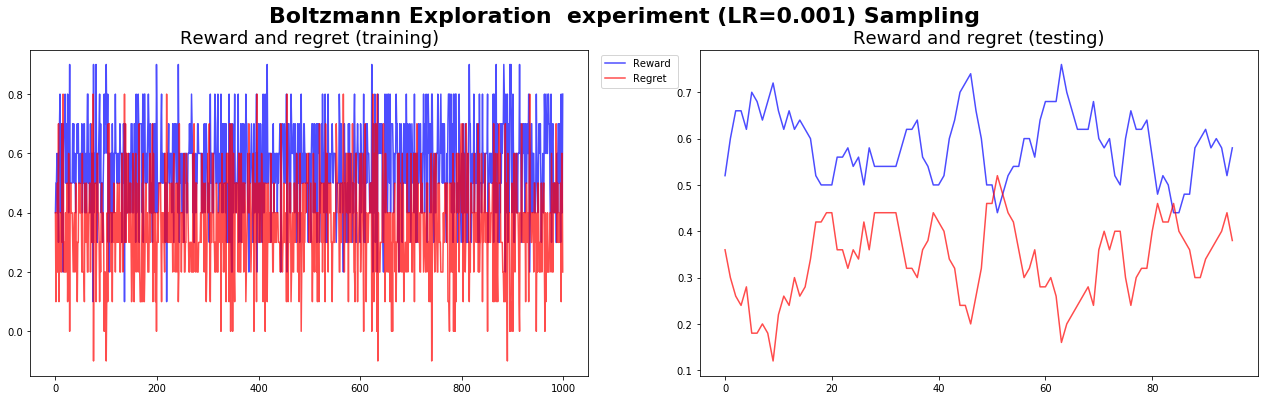

In [0]:
boltzman_experiment_helper(environment_builder,0.001)

For higher learning rates sampling strategies work better. However, greedy strategy is preferable for lower rates.

One may notice that case of `LR=0.1` is very similar to expected plot (see Expected results).

All-in-all, Boltzman Exploration seemed to achive higher results in the best case then the best of UCB.

### Tompson Sampling

Good news about Tompson Sampling is that it does not have any parameters (seed does not count), so there is no need for parameter search.

Bad news that it is theoretically works only with greedy starategy. Nevertheless it does not meant we are not ready to try it (even if we have no positive expectation because sampling with sampled probabilities does not seem like a good idea).

In [0]:
tompson_builder = lambda s: TompsonSamplingAlgorithm(NUMBER_OF_ARMS,seed=s)

Trial 10 of 10
Trial 10 of 10


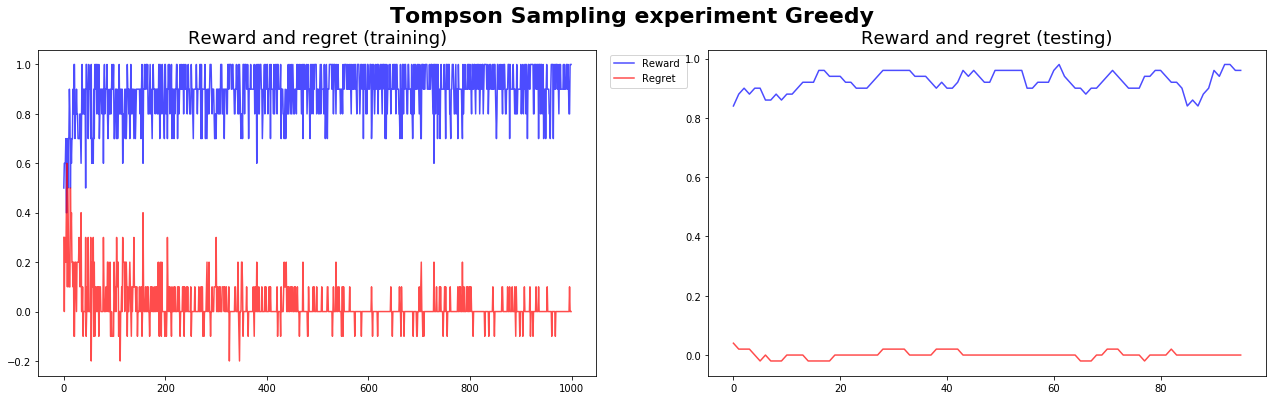

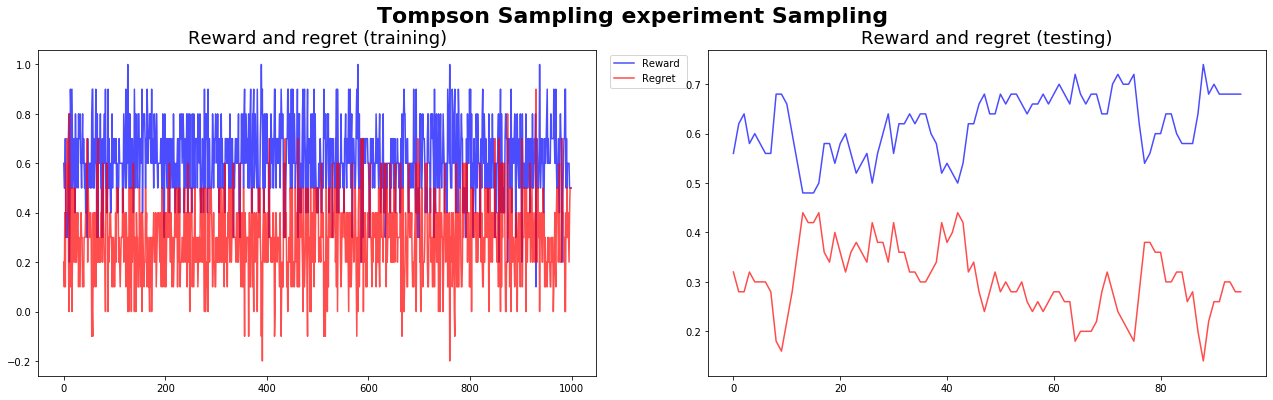

In [0]:
res = run_experiment(environment_builder, tompson_builder,RUNS_TO_AVERAGE,masterseed=SEED,greedy=True)
plot_results(res,"Tompson Sampling experiment Greedy")
res = run_experiment(environment_builder, tompson_builder,RUNS_TO_AVERAGE,masterseed=SEED,greedy=False)
# obviously "Tompson Sampling experiment Sampling" is a tautology, but it is not the reason to change the title
plot_results(res,"Tompson Sampling experiment Sampling")

As it was already mentioned sampling stratedy is not suitable for Tompson Sampling, and now we have a proof of it.

Tompson Sampling results are similar or slightly higher than the best case of Boltzman Exploration.

## Results Discussion

Looking on obtained results in comparison to presented early expectations we can inference that results on best cases convergence times faster than expectations. Surely, speaking about convergence we don't look on baseline that does not convergence because it does not train at all.
Moreover, one could see that non-optimal parameters produce results that look very similar to baseline results.

It is also known that each training algorithm have preferences on strategy. And thus even if sampling strategy works for algorithm with deterministic preferences and vice versa the performance would be worse even with near-optimal parameter choice. Experiments support the point of view.
